<a href="https://colab.research.google.com/github/Balitskyi/Shahed-Missile-Analytics/blob/main/%D0%A8%D0%B0%D1%85%D0%B5%D0%B4%D0%BE_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B0_%D0%B0%D0%BD%D0%B0%D0%BB%D1%96%D1%82%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
#!pip update -y numpy pmdarima
#!pip install numpy==1.23.5 pandas==1.5.3 scipy==1.10.1 statsmodels==0.13.5 scikit-learn==1.2.2 matplotlib==3.6.3 pmdarima==2.0.3
#!pip install pandas==2.1.4

In [77]:
import math as mt
import numpy as np
import pandas as pd
import re
import requests
import warnings
from bs4 import BeautifulSoup
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px

from datetime import datetime, timedelta
from io import StringIO
import calendar
import json
from google.colab import files

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

#import tensorflow as tf

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
#from tensorflow.keras.callbacks import EarlyStopping

#from keras.models import Sequential
#from keras.layers import LSTM, Dense, Input

from statsmodels.tsa.statespace.sarimax import SARIMAX
#from pmdarima import auto_arima

# Вимкнути попередження FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
#warnings.simplefilter("ignore", ConvergenceWarning)

In [78]:
urls_s = [
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D0%B0%D1%82%D0%B0%D0%BA_%D0%91%D0%BF%D0%9B%D0%90_Shahed_136_%D1%83_2022_%D1%80%D0%BE%D1%86%D1%96', #2022
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D0%B0%D1%82%D0%B0%D0%BA_%D0%91%D0%BF%D0%9B%D0%90_Shahed_136_%D1%83_2023_%D1%80%D0%BE%D1%86%D1%96', #2023
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D0%B0%D1%82%D0%B0%D0%BA_%D0%91%D0%BF%D0%9B%D0%90_Shahed_136_%D1%83_2024_%D1%80%D0%BE%D1%86%D1%96', #2024
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D0%B0%D1%82%D0%B0%D0%BA_%D0%91%D0%BF%D0%9B%D0%90_Shahed_136_%D1%83_1_%D0%BF%D0%BE%D0%BB%D0%BE%D0%B2%D0%B8%D0%BD%D1%96_2025_%D1%80%D0%BE%D0%BA%D1%83', #2025_1_половина
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D0%B0%D1%82%D0%B0%D0%BA_%D0%91%D0%BF%D0%9B%D0%90_Shahed_136_%D1%83_2_%D0%BF%D0%BE%D0%BB%D0%BE%D0%B2%D0%B8%D0%BD%D1%96_2025_%D1%80%D0%BE%D0%BA%D1%83', #2025_2_половина
    # + інші URL
]

# Створення списку для об'єктів BeautifulSoup та HTTP-запитів
responses = []
soups = []

# Виконання HTTP-запитів та створення об'єктів BeautifulSoup
for url in urls_s:
    response = requests.get(url)
    responses.append(response)
    soups.append(BeautifulSoup(response.text, 'html.parser'))


def clean_table(table_html):
    return BeautifulSoup(str(table_html), 'html.parser')

HEADERS = {
    "User-Agent": "Mozilla/5.0"
}

def get_dataframe(url):
    response = requests.get(url, headers=HEADERS)
    soup = BeautifulSoup(response.text, 'html.parser')

    # шукаємо всі таблиці, де серед класів є 'wikitable'
    tables = soup.find_all('table', class_=lambda c: c and 'wikitable' in c)

    if len(tables) <= 1:
        print(f"⚠️ Для {url} таблиць < 2, пропустити першу неможливо")
        return []

    # пропускаємо першу таблицю
    needed_tables = tables[1:]

    return [pd.read_html(StringIO(str(table)))[0] for table in needed_tables]

# отримання даних для всіх років
dataframes_s = [get_dataframe(url) for url in urls_s]

# плоский список
flat_dfs = [df for df_list in dataframes_s for df in df_list]

if not flat_dfs:
    raise ValueError("Жодної таблиці не вдалося зчитати!")

df_s = pd.concat(flat_dfs, ignore_index=True)# Список URL-ів

In [79]:
df_s['дата'] = df_s['дата'].str.replace(r'.23', '.2023', regex=False)
df_s['дата'] = df_s['дата'].str.replace(r'.24', '.2024', regex=False)
df_s['дата'] = df_s['дата'].str.replace(r'.25', '.2025', regex=False)

df_s = df_s.reset_index(drop = True)

df_s.iat[369,3] = 35
df_s.iat[370,3] = 35
df_s.iat[371,3] = 35

# Вставка нових рядків
new_rows = pd.DataFrame({'дата': ['08.01.2023', '14.01.2023', '20.01.2023', '31.01.2023', '05.01.2023'],
                         'регіон': ['Україна', 'Україна', 'Україна', 'Україна', 'Україна'],
                         'місце': ['Україна', 'Україна', 'Україна', 'Україна', 'Україна'],
                         'всього': [1, 1, 1,1,1],
                         'влучань': [0, 0, 0,0,0],
                         'влучання': ['—', '—', '—', '—', '—'],
                         'жертви': ['—','—', '—', '—', '—']})

# Вставка нових рядків між 78-м та 79-м рядками
df_s = pd.concat([df_s.iloc[:79], new_rows, df_s.iloc[79:]]).reset_index(drop=True)

new_rows2 = pd.DataFrame({'дата': ['26.11.2022', '01.12.2022'],
                         'регіон': ['Україна', 'Україна'],
                         'місце': ['Україна', 'Україна'],
                         'всього': [1, 1],
                         'влучань': [0, 0],
                         'влучання': ['—', '—'],
                         'жертви': ['—','—']})

# Вставка нових рядків між 55-м та 56-м рядками
df_s = pd.concat([df_s.iloc[:56], new_rows2, df_s.iloc[56:]]).reset_index(drop=True)

#df_s

In [98]:
shahed=df_s.rename(columns = {'дата': 'date', 'регіон':'region', 'місце':'city', 'всього':'launched', 'влучань':'impacts', 'влучання':'details', 'жертви':'casualties'})
shahed.set_index('date')

#shahed['impacts'] = shahed['impacts'].str.replace('<', '', regex=True) #якимось чином цей рядок прибирав усі значення в стовпчику для червня
shahed['impacts'] = shahed['impacts'].astype(str)
shahed['launched'] = shahed['launched'].astype(str)

def replace_plus(match):
    number = int(match.group(1))
    return str(number + 1)

# Застосування регулярного виразу до стовпця
shahed['launched'] = shahed['launched'].apply(lambda x: re.sub(r'(\d+)\+', replace_plus, x))
shahed['impacts'] = shahed['impacts'].apply(lambda x: re.sub(r'(\d+)\+', replace_plus, x))
shahed['launched'] = shahed['launched'].apply(lambda x: re.sub(r'(\d+)\>', replace_plus, x))
shahed['impacts'] = shahed['impacts'].apply(lambda x: re.sub(r'(\d+)\>', replace_plus, x))
shahed['launched'] = shahed['launched'].str.replace(r'\[\d+\]', '', regex=True)
shahed['impacts'] = shahed['impacts'].str.replace(r'\[\d+\]', '', regex=True)
shahed['details'] = shahed['details'].str.replace(r'\[\d+\]', '', regex=True)
shahed['region'] = shahed['region'].str.replace(r'\[\d+\]', '', regex=True)
shahed['city'] = shahed['city'].str.replace(r'\[\d+\]', '', regex=True)

shahed.launched = shahed.launched.replace({'—':'0'})

shahed['launched'] = (
    shahed['launched']
    .astype(str)
    .str.replace(r'^(\d+)\.0$', r'\1', regex=True)  # прибирає ".0" у кінці числа
    .replace(['.0', '0.0'], '0')                    # окремий випадок — тільки ".0" або "0.0"
    .replace('', '0')                               # якщо раптом залишився порожній рядок
)


shahed.launched = shahed.launched.fillna(0)
shahed.impacts = shahed.impacts.replace({'—':'0'})

shahed = shahed[shahed['launched'] != "Мобільні вогневі групи протиповітряної оборони за 2 січня знищили 47% безпілотників та 19% крилатих ракет у Північній операційній зоні"]
shahed
# Заміна "nan" на 0 перед перетворенням типу даних

shahed = shahed[~shahed['launched'].astype(str).str.contains('<')]
shahed['launched'] = shahed['launched'].astype(float).astype('Int64') #було <20, які залетіли до поляків

shahed.loc[:, 'launched'] = shahed['launched'].astype(int)
shahed.loc[:, 'city'] = shahed['city'].fillna('Невідомо')
shahed['impacts'] = shahed['impacts'].fillna(0)
shahed['impacts'] = pd.to_numeric(shahed['impacts'], errors='coerce', downcast='integer')
shahed['impacts'] = shahed['impacts'].fillna(0).astype(int)
shahed.loc[:, 'casualties'] = shahed['casualties'].replace({'—':'даних про жертв немає'})
shahed.loc[:, 'casualties'] = shahed['casualties'].fillna('даних про жертв немає')
shahed.loc[:, 'details'] = shahed['details'].fillna('не встановлено')
shahed.loc[:, 'details'] = shahed['details'].str.replace(r'^\s+', '', regex=True)
shahed.loc[:, 'region'] = shahed['region'].replace({'—':'Україна'})

replacements_location = {
    'південь': 'Південь',
    'північ': 'Північ',
    'центр': 'Центр',
    'Південь та Центр України': 'Центр та Південь України',
    'схід': 'Схід',
    'захід': 'Захід',
    'Україна (повторна атака)': 'Україна',
    'область': 'обл.'
}

shahed['region'] = shahed['region'].replace(replacements_location, regex=True)
shahed.loc[:, 'details'] = shahed['details'].str.ljust(0)
shahed = shahed[shahed['date'] != "—"] #####################################################################################################
shahed.loc[:, 'date'] = pd.to_datetime(shahed['date'], format="%d.%m.%Y")
shahed.loc[:, 'intercepted'] = shahed['launched'] - shahed['impacts']
shahed.loc[:, 'missile_type'] = 'Shahed'

new_columns = list(shahed.columns[:3]) + [shahed.columns[-1]] + list(shahed.columns[3:-1])
shahed = shahed[new_columns]

shahed = shahed.drop(['impacts'], axis = 1)
neww_columns = list(shahed.columns[:4]) + list(shahed.columns[5:7]) + [shahed.columns[4]] + [shahed.columns[-1]]
shahed = shahed[neww_columns]

# Групуємо дані за стовпчиком 'date' та застосовуємо функцію для заміни значень
shahed['launched'] = shahed.groupby('date', group_keys=False)['launched'].apply(lambda x: x.mask(x.duplicated(), 0))
shahed['intercepted'] = shahed.groupby('date', group_keys=False)['intercepted'].apply(lambda x: x.mask(x.duplicated(), 0))

#shahed.to_csv('/content/drive/MyDrive/Colab Notebooks/shaheds_updated.csv',  encoding='utf-8', index = False)

shahed = shahed.reset_index(drop=True)

shahed = shahed.drop(shahed.index[379])
shahed = shahed.drop(shahed.index[290])
shahed = shahed.drop(shahed.index[286])
shahed = shahed.reset_index(drop=True)

shahed.iat[256,6] = 25
shahed.iat[256,7] = 20
shahed.iat[257,6] = 10
shahed.iat[257,7] = 6
shahed.iat[258,6] = 5
shahed.iat[258,7] = 4
shahed.iat[286,6] = 19
shahed.iat[286,7] = 18
shahed.iat[288,6] = 17
shahed.iat[288,7] = 11
shahed.iat[289,6] = 23
shahed.iat[289,7] = 13


shahed['date'] = pd.to_datetime(shahed['date'])

shahed1 = shahed.copy()
shahed2 = shahed.copy()

shahed

#shahed.head(460)

#shahed.intercepted.sum()
#shahed.launched.sum()

,date,region,city,missile_type,details,casualties,launched,intercepted
0,2022-09-12,Харківська обл.,Куп'янськ,Shahed,"не встановлено, зафіксовано серійний номер: М214",даних про жертв немає,1,1
1,2022-09-15,Дніпропетровська обл.,Нікополь,Shahed,"не встановлено, зафіксовано серійний номер: М229",даних про жертв немає,1,1
2,2022-09-20,Миколаївська обл.,Очаків,Shahed,"інфраструктура порту, зафіксовано серійний ном...",даних про жертв немає,1,0
3,2022-09-22,Миколаївська обл.,Миколаївська обл.,Shahed,Підрозділом 160 ЗРБр було збито одразу чотири ...,даних про жертв немає,4,4
4,2022-09-23,Одеська обл.,Одеса,Shahed,"1 збитий, 2 влучили у адмінбудівлю в припортов...",1 загиблий,3,1
...,...,...,...,...,...,...,...,...
2631,2025-12-16,Запорізька обл.,Запоріжжя,Shahed,удар по житловій багатоповерхівці,3 поранено,0,0
2632,2025-12-16,Україна,Україна,Shahed,два БпЛА були у повітрі 16 грудня,даних про жертв немає,2,2
2633,2025-12-17,"Центр, Південь та Схід України","центр, південь та схід України",Shahed,37 збиті ППО та локаційно втрачено,даних про жертв немає,66,37
2634,2025-12-17,Одеська обл.,Одеська обл.,Shahed,удар по цивільному транспортному об'єкту,даних про жертв немає,0,0


In [81]:
#shahed.loc[shahed['region'] == 'Харківська обл.']
#shahed.head(290)

# Вибір рядків, де значення останнього стовпчика ('останній_стовпець') більше за передостанній ('передостанній_стовпець')
#filtered_rows = shahed[shahed.iloc[:, -1] > shahed.iloc[:, -2]]
#filtered_rows
#plot_shahed
#df_grouped
#shahed.groupby(shahed['date'].dt.to_period('M'))[['launched', 'intercepted']].sum()

In [82]:
shahed_total = shahed[shahed['launched'] != 0]

n = shahed_total.groupby(shahed_total.region)[['launched','intercepted']].sum().sort_values(by = 'launched', ascending = False)
# Видаляємо рядки, де launched = 0 (хоча їх впринципі немає бути)
n = n[n['launched'] != 0].reset_index(drop=True)

n['interc_perc'] = ((n['intercepted'] / n['launched']) * 100).apply(lambda x: round(x, 1))

n.sort_values(by = 'interc_perc', ascending = True, inplace = True)

m = round(((n.intercepted.sum()) / (n.launched.sum()) * 100), 1)
print('ППО України знищують близько', m, '% ворожих шлюхедів.\n')

n.launched.sum()

ППО України знищують близько 87.6 % ворожих шлюхедів.



np.int64(67892)

In [83]:
plot_shahed1 = shahed1

# Згрупувати дані по тижнях та обчислити середнє значення 'launched' для кожного тижня
plot_shahed1['week'] = plot_shahed1['date'].dt.to_period('W')
# Групування за тижнями та обчислення суми по стовпцях 'launched' та 'intercepted'
df_grouped = plot_shahed1.groupby('week')[['launched', 'intercepted']].sum().reset_index()

df_grouped

plot_shahed1

,date,region,city,missile_type,details,casualties,launched,intercepted,week
0,2022-09-12,Харківська обл.,Куп'янськ,Shahed,"не встановлено, зафіксовано серійний номер: М214",даних про жертв немає,1,1,2022-09-12/2022-09-18
1,2022-09-15,Дніпропетровська обл.,Нікополь,Shahed,"не встановлено, зафіксовано серійний номер: М229",даних про жертв немає,1,1,2022-09-12/2022-09-18
2,2022-09-20,Миколаївська обл.,Очаків,Shahed,"інфраструктура порту, зафіксовано серійний ном...",даних про жертв немає,1,0,2022-09-19/2022-09-25
3,2022-09-22,Миколаївська обл.,Миколаївська обл.,Shahed,Підрозділом 160 ЗРБр було збито одразу чотири ...,даних про жертв немає,4,4,2022-09-19/2022-09-25
4,2022-09-23,Одеська обл.,Одеса,Shahed,"1 збитий, 2 влучили у адмінбудівлю в припортов...",1 загиблий,3,1,2022-09-19/2022-09-25
...,...,...,...,...,...,...,...,...,...
2631,2025-12-16,Запорізька обл.,Запоріжжя,Shahed,удар по житловій багатоповерхівці,3 поранено,0,0,2025-12-15/2025-12-21
2632,2025-12-16,Україна,Україна,Shahed,два БпЛА були у повітрі 16 грудня,даних про жертв немає,2,2,2025-12-15/2025-12-21
2633,2025-12-17,"Центр, Південь та Схід України","центр, південь та схід України",Shahed,37 збиті ППО та локаційно втрачено,даних про жертв немає,66,37,2025-12-15/2025-12-21
2634,2025-12-17,Одеська обл.,Одеська обл.,Shahed,удар по цивільному транспортному об'єкту,даних про жертв немає,0,0,2025-12-15/2025-12-21


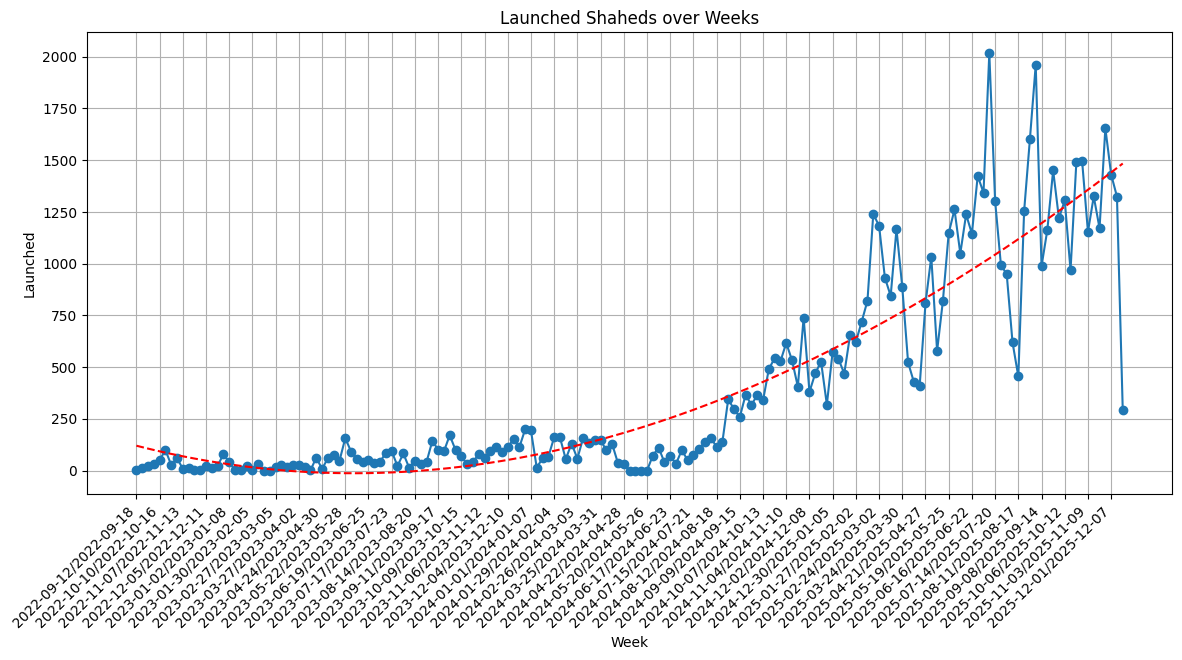

In [84]:
plot_shahed1 = shahed1

# Згрупувати дані по тижнях та обчислити середнє значення 'launched' для кожного тижня
plot_shahed1['week'] = plot_shahed1['date'].dt.to_period('W')
# Групування за тижнями та обчислення суми по стовпцях 'launched' та 'intercepted'
df_grouped = plot_shahed1.groupby('week')[['launched', 'intercepted']].sum().reset_index()
df_grouped['launched'] = df_grouped['launched'].astype(int)
df_grouped['intercepted'] = df_grouped['intercepted'].astype(int)

# Обчислення відсотку перехоплення
df_grouped['interc_perc'] = round((df_grouped['intercepted'] / df_grouped['launched']) * 100, 1)

# Створення діапазону тижнів без пропусків
ideal_weeks = pd.date_range(start="2022-09-12", end=pd.Timestamp.today(), freq='W-MON')

df_grouped['week'] = df_grouped['week'].dt.to_timestamp()

# Перевірка наявності всіх тижнів у df_grouped
missing_weeks = ideal_weeks[~ideal_weeks.isin(df_grouped['week'])]

# Якщо відсутні тижні, додати нові рядки до df_grouped зі значеннями за замовчуванням
if not missing_weeks.empty:
    new_rows = pd.DataFrame({
        'week': missing_weeks,
        'launched': 0,
        'intercepted': 0,
        'interc_perc': 100.0,
        'week_number': range(len(df_grouped) + 1, len(df_grouped) + len(missing_weeks) + 1)
    })
    df_grouped = pd.concat([df_grouped, new_rows]).reset_index(drop=True)

date_format = "%Y-%m-%d"

# Перетворення початкової та кінцевої дат кожного тижня у потрібний формат
df_grouped['week'] = df_grouped['week'].dt.to_period('W-SUN').apply(lambda r: f"{r.start_time.strftime(date_format)}/{(r.end_time).strftime(date_format)}")
df_grouped = df_grouped.sort_values('week').reset_index(drop=True)

df_grouped['week_number'] = range(1, len(df_grouped) + 1)

# Побудова лінійного графіка
plt.figure(figsize=(14, 6))  # Задаємо розміри графіка
plt.plot(df_grouped['week_number'], df_grouped['launched'], marker='o', linestyle='-')  # Побудова графіка

week_numbers = df_grouped[df_grouped['week_number'] % 4 == 1]['week_number']  # Вибираємо тижні з першого тижня з кроком 4
week_dates = df_grouped[df_grouped['week_number'] % 4 == 1]['week']  # Вибираємо дати кожного четвертого тижня
plt.xticks(week_numbers, week_dates, rotation=45, ha='right')  # Обертаємо та відображаємо мітки

# Побудова нелінійного тренду (поліном другого степеня)
z = np.polyfit(df_grouped['week_number'], df_grouped['launched'], 3) # ставити 2й степінь полінома (але можна погратись і пошукати інші значення)
p = np.poly1d(z)
plt.plot(df_grouped['week_number'], p(df_grouped['week_number']), "r--")

# Додавання заголовків та підписів до осей
plt.xlabel('Week')
plt.ylabel('Launched')
plt.title('Launched Shaheds over Weeks')

# Відображення сітки на графіку
plt.grid(True)

# Показ графіка
plt.show()

In [85]:
df_grouped

,week,launched,intercepted,interc_perc,week_number
0,2022-09-12/2022-09-18,2,2,100.0,1
1,2022-09-19/2022-09-25,14,7,50.0,2
2,2022-09-26/2022-10-02,23,21,91.3,3
3,2022-10-03/2022-10-09,31,21,67.7,4
4,2022-10-10/2022-10-16,50,34,68.0,5
...,...,...,...,...,...
166,2025-11-17/2025-11-23,1171,1002,85.6,167
167,2025-11-24/2025-11-30,1655,1467,88.6,168
168,2025-12-01/2025-12-07,1431,1143,79.9,169
169,2025-12-08/2025-12-14,1324,1047,79.1,170


In [86]:
df_ml = df_grouped
df_ml = df_ml.drop(['week'], axis=1)
df_ml = df_ml.drop(['interc_perc'], axis=1)
df_ml = df_ml.drop(['intercepted'], axis=1)
df_ml.set_index('week_number', inplace=True)


df_ml = df_ml.drop(df_ml.index[148]) #видаляю останній тиждень, бо він поки не повний
#df_ml

In [87]:
# Розділення даних на навчальний та тестовий набори
train_size = int(len(df_ml) * 0.99) #цифра вказує на якому куску даних буде вчитись нейронка (0,8-1) самий топ. але графік буде будуватись після навчальної вибірки (!)
train, test = df_ml['launched'][:train_size], df_ml['launched'][train_size:]

# Побудова ARIMA моделі
model1 = ARIMA(train, order=(119,1,0)) #кожен тиждень міняти цифру
#model_fit1 = model1.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [88]:
"""# Прогнозування майбутніх значень
forecast_steps = len(df_ml) - train_size
#forecast = model_fit1.get_forecast(steps=len(df_ml) - 50).predicted_mean #кількість передбачених значень
#forecast = np.maximum(forecast, 0)

# Визначення кінцевої дати - 210 днів після сьогоднішнього дня
end_date = datetime.now() + timedelta(days=210)

# Створення діапазону дат від '2022-09-11' до кінцевої дати
all_dates = pd.date_range(start='2022-09-11', end=end_date)

# Розбиття дат на тижні
weekly_dates = pd.date_range(start=all_dates.min(), end=all_dates.max(), freq='W-SUN')

# Створення змінної для осі x з діапазонами дат у вказаному форматі
x_axis = pd.Series(weekly_dates.strftime('%Y-%m-%d') + '/' + (weekly_dates + pd.DateOffset(days=7)).strftime('%Y-%m-%d'))

# Задаємо кількість тижнів
week_numbers_new = pd.Series(range(1, len(weekly_dates) + 1))

# Фільтруємо мітки осі X кожні 4 тижні
x_axis_quarterly = x_axis[::4]
week_numbers_quarterly = week_numbers_new[::4]

# Виведення графіка з оновленою осі x
plt.figure(figsize=(10, 6))
plt.plot(df_ml.index, df_ml, color='black', label='Actual')
#plt.plot(forecast.index, forecast, color='red', label='Forecast')
plt.xticks(week_numbers_quarterly, x_axis_quarterly, rotation=45, ha='right')  # Обертаємо та відображаємо мітки
plt.legend()
plt.title('ARIMA Forecasting')
plt.xlabel('Week Number')
plt.ylabel('Launched')
plt.grid(True)
plt.show()"""

"# Прогнозування майбутніх значень\nforecast_steps = len(df_ml) - train_size\n#forecast = model_fit1.get_forecast(steps=len(df_ml) - 50).predicted_mean #кількість передбачених значень\n#forecast = np.maximum(forecast, 0)\n\n# Визначення кінцевої дати - 210 днів після сьогоднішнього дня\nend_date = datetime.now() + timedelta(days=210)\n\n# Створення діапазону дат від '2022-09-11' до кінцевої дати\nall_dates = pd.date_range(start='2022-09-11', end=end_date)\n\n# Розбиття дат на тижні\nweekly_dates = pd.date_range(start=all_dates.min(), end=all_dates.max(), freq='W-SUN')\n\n# Створення змінної для осі x з діапазонами дат у вказаному форматі\nx_axis = pd.Series(weekly_dates.strftime('%Y-%m-%d') + '/' + (weekly_dates + pd.DateOffset(days=7)).strftime('%Y-%m-%d'))\n\n# Задаємо кількість тижнів\nweek_numbers_new = pd.Series(range(1, len(weekly_dates) + 1))\n\n# Фільтруємо мітки осі X кожні 4 тижні\nx_axis_quarterly = x_axis[::4]\nweek_numbers_quarterly = week_numbers_new[::4]\n\n# Виведення г

In [99]:
shahed_test = shahed1
# Вибираємо стовпці за їхніми позиціями
scolumn_6 = shahed_test.iloc[:, 7]
scolumn_7 = shahed_test.iloc[:, 6]

# Видаляємо стовпчик на позиції 4
shahed_test.drop(columns=['city'], inplace=True)
shahed_test.drop(columns=['launched'], inplace=True)
shahed_test.drop(columns=['intercepted'], inplace=True)
shahed_test.drop(columns=['casualties'], inplace=True)

# Вставляємо стовпці на нові позиції
shahed_test.insert(loc=2, column='intercepted', value=scolumn_6)
shahed_test.insert(loc=3, column='launched', value=scolumn_7)

In [96]:
#shahed_test.set_index('date', inplace=True)

SyntaxError: invalid character '№' (U+2116) (ipython-input-1435826212.py, line 1)

In [101]:
# Функція для коректної агрегації текстових полів
def unique_values_to_string(values):
    cleaned = {str(v).strip() for v in values if pd.notna(v) and str(v).strip() != ''}
    return ', '.join(sorted(cleaned))

shahed_test['launched'] = (shahed_test['launched'].fillna(0).astype(int))
shahed_test['intercepted'] = (shahed_test['intercepted'].fillna(0).astype(int))


# Агрегація
shahed_agg = (shahed_test.groupby('date', as_index=False).agg(
        launched=('launched', 'max'),
        intercepted=('intercepted', 'max'),
        region=('region', unique_values_to_string),
        missile_type=('missile_type', unique_values_to_string),
        details=('details', unique_values_to_string)
    )
)

# перехоплених не може бути більше, ніж запущених
shahed_agg['intercepted'] = shahed_agg[['intercepted', 'launched']].min(axis=1)
shahed_agg['launched'] = shahed_agg['launched'].astype(int)
shahed_agg['intercepted'] = shahed_agg['intercepted'].astype(int)

shahed_agg.tail(100)

,date,launched,intercepted,region,missile_type,details
731,2025-09-09,84,61,"Донецька обл., Запорізька обл., Україна",Shahed,"61 збиті ППО та локаційно втрачено, атакований..."
732,2025-09-10,415,386,"Волинська обл., Вінницька обл., Житомирська об...",Shahed,"386 збиті ППО та локаційно втрачено, атаковано..."
733,2025-09-11,66,62,"Сумська обл., Центр, Південь та Схід України, ...",Shahed,"62 збиті ППО та локаційно втрачено, атаковано ..."
734,2025-09-12,40,34,"Сумська обл., Центр та Схід України",Shahed,"34 збиті ППО та локаційно втрачено, атаковане ..."
735,2025-09-13,164,137,"Донецька обл., Харківська обл., Центр, Південь...",Shahed,"137 збиті ППО та локаційно втрачено, атаковано..."
...,...,...,...,...,...,...
826,2025-12-13,465,417,"Дніпропетровська обл., Миколаївська обл., Одес...",Shahed,"417 збиті ППО та локаційно втрачено, атаковано..."
827,2025-12-14,120,110,"Дніпропетровська обл., Запорізька обл., Одеськ...",Shahed,"110 збиті ППО та локаційно втрачено, атаковано..."
828,2025-12-15,150,133,"Дніпропетровська обл., Україна, Центр, Південь...",Shahed,"133 збиті ППО та локаційно втрачено, атакована..."
829,2025-12-16,67,57,"Запорізька обл., Одеська обл., Південь та Схід...",Shahed,"57 збиті ППО та локаційно втрачено, атаковано ..."


/tmp/ipython-input-385806420.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_100_days['launched_rolling'] = last_100_days['launched'].rolling(window=7, min_periods=1).mean()


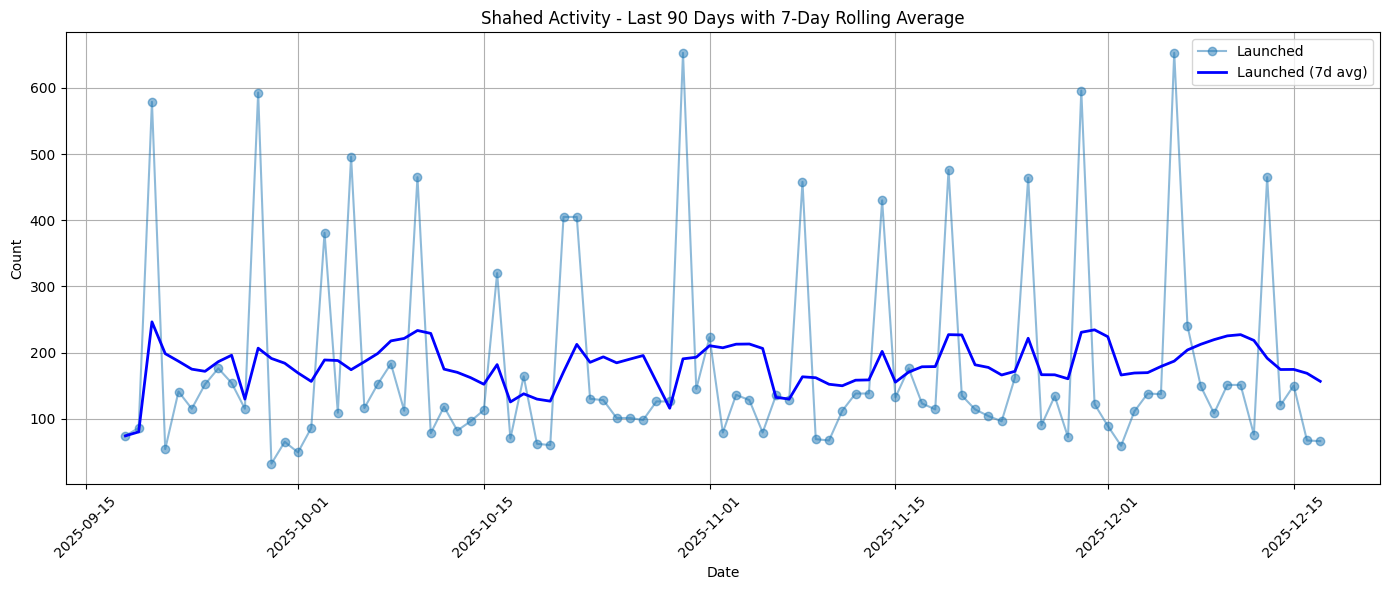

In [102]:
# Перетворення дати
shahed_agg['date'] = pd.to_datetime(shahed_agg['date'])

# Відсортувати за датою та взяти останні 100 днів
shahed_agg_sorted = shahed_agg.sort_values('date')
last_100_days = shahed_agg_sorted[shahed_agg_sorted['date'] >= shahed_agg_sorted['date'].max() - pd.Timedelta(days=90)] #дні міняти тут

# Розрахунок ковзного середнього за 7 днів
last_100_days['launched_rolling'] = last_100_days['launched'].rolling(window=7, min_periods=1).mean()
#last_100_days['intercepted_rolling'] = last_100_days['intercepted'].rolling(window=7, min_periods=1).mean()

# Побудова графіка
plt.figure(figsize=(14, 6))

# Сирові значення
plt.plot(last_100_days['date'], last_100_days['launched'], label='Launched', marker='o', linestyle='-', alpha=0.5)
#plt.plot(last_100_days['date'], last_100_days['intercepted'], label='Intercepted', marker='x', linestyle='-', alpha=0.5)

# Ковзні середні
plt.plot(last_100_days['date'], last_100_days['launched_rolling'], label='Launched (7d avg)', color='blue', linewidth=2)
#plt.plot(last_100_days['date'], last_100_days['intercepted_rolling'], label='Intercepted (7d avg)', color='orange', linewidth=2)

# Форматування
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Shahed Activity - Last 90 Days with 7-Day Rolling Average')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [103]:
last_100_days['launched'].mean()

np.float64(180.5054945054945)

In [104]:
today = datetime.today()
days_in_month = calendar.monthrange(today.year, today.month)[1]

ukrainian_months = { #у родовому відмінку
    1: "січень", 2: "лютий", 3: "березень", 4: "квітень", 5: "травень", 6: "червень",
    7: "липень", 8: "серпень", 9: "вересень", 10: "жовтень", 11: "листопад", 12: "грудень"
}

shahed_agg['month'] = pd.to_datetime(shahed_agg['date']).dt.to_period('M')
shahed_agg['day'] = pd.to_datetime(shahed_agg['date']).dt.to_period('d')
shahed_agg['year'] = pd.to_datetime(shahed_agg['date']).dt.to_period('Y')

# Знаходимо місяць із найбільшою кількістю запусків
launch_per_month = shahed_agg.groupby('month')['launched'].sum()
interc_per_month = shahed_agg.groupby('month')['intercepted'].sum()
max_month = launch_per_month.idxmax()
max_value = launch_per_month.max()

# Отримуємо номер місяця та рік
month_number = max_month.month
year = max_month.year

# Отримуємо назву місяця українською
month_name = ukrainian_months[month_number]
#==============================================================================================================

current_month = pd.Timestamp.today().to_period('M')
last_month_data = shahed_agg[pd.to_datetime(shahed_agg['date']).dt.to_period('M') == current_month]
#last_month_data = shahed_agg[pd.to_datetime(shahed_agg['date']).dt.to_period('M') == '2025-04'] #зробити шоб місяці мінялися динамічно

last_sunday = pd.Timestamp.today().normalize() - pd.DateOffset(days=pd.Timestamp.today().weekday() + 1)
last_monday = last_sunday - pd.DateOffset(days=6)
current_monday = today - timedelta(days=today.weekday())
current_sunday = current_monday + timedelta(days=6)

last_week_data = shahed_agg[(shahed_agg['date'] >= last_monday) & (shahed_agg['date'] <= last_sunday)]
this_week_data = shahed_agg[(shahed_agg['date'] > last_sunday) & (shahed_agg['date'] <= current_sunday)]

# Розраховуємо суму для стовпців "launched" та "intercepted"
total_launched = last_month_data['launched'].sum()
total_intercepted = last_month_data['intercepted'].sum()
#==============================================================================================================
ukrainian_months_d = { #у родовому відмінку
    1: "січня", 2: "лютого", 3: "березня", 4: "квітня", 5: "травня", 6: "червня",
    7: "липня", 8: "серпня", 9: "вересня", 10: "жовтня", 11: "листопада", 12: "грудня"
}

# Знаходимо день із найбільшою кількістю запусків
launch_per_day = shahed_agg.groupby('day')['launched'].sum()
max_day = launch_per_day.idxmax()
max_value_day = launch_per_day.max()
# Отримуємо номер місяця та рік
day_number = max_day.day
month_number_d = max_day.month
year_d = max_day.year
month_name_d = ukrainian_months_d[month_number_d]
#==============================================================================================================
today_d = pd.Timestamp.today().normalize()
today_data_l = (shahed_agg[(shahed_agg['date'] == today_d)]).launched.max()
today_data_i = (shahed_agg[(shahed_agg['date'] == today_d)]).intercepted.max()
#==============================================================================================================
today_day = today.date().day
today_month = today.date().month
today_month = ukrainian_months_d[today_month].upper()
#==============================================================================================================
launch_per_year = shahed_agg.groupby('year')['launched'].sum()
s_year2022 = launch_per_year.loc[launch_per_year.index.year == 2022].item()
s_year2023 = launch_per_year.loc[launch_per_year.index.year == 2023].item()

In [105]:
# Групування і заповнення пропущених днів
df_ss = shahed_agg[['date', 'launched']].copy()
df_ss['date'] = pd.to_datetime(df_ss['date'])
df_ss = df_ss.groupby('date').sum().asfreq('D', fill_value=0)

In [106]:
#НАКОПИЧЕННЯ
def detect_accumulation_periods(df, threshold=150, min_length=3):
    """
    Створює ознаку накопичення: кількість днів поспіль із малими значеннями.

    threshold — максимум, який вважається "мало"
    min_length — мінімальна кількість днів, яку треба накопичувати
    """
    accumulation_days = []
    count = 0
    for value in df['launched']:
        if value <= threshold:
            count += 1
        else:
            # Атака — обнуляємо
            count = 0
        accumulation_days.append(count)
    df['accumulated_days'] = accumulation_days
    # Також можна окремо маркувати дні, коли була масова атака
    df['massive_attack'] = df['launched'] > 250
    return df

In [107]:
df_ss = detect_accumulation_periods(df_ss, threshold=150, min_length=3)
df_ss['rolling_mean_5'] = df_ss['launched'].rolling(5).mean().fillna(0)
df_ss['std_5'] = df_ss['launched'].rolling(5).std().fillna(0)
df_ss['weekday'] = df_ss.index.weekday / 6  # нормалізований день тижня (0–1)

In [108]:
# Переконаємося, що індекс типу datetime
df_ss.index = pd.to_datetime(df_ss.index)

# Визначимо останню дату в даних
last_date = df_ss.index.max()

# Обчислимо дату, яка на 365 днів раніше
cutoff_date = last_date - pd.Timedelta(days=365)

# Відфільтруємо дані, залишивши тільки останні 365 днів
df_ss_last_year = df_ss[df_ss.index > cutoff_date]

In [109]:
df_ss_last_year

,launched,accumulated_days,massive_attack,rolling_mean_5,std_5,weekday
date,,,,,,
2024-12-18,81,5,False,78.4,41.137574,0.333333
2024-12-19,85,6,False,69.4,30.599020,0.500000
2024-12-20,65,7,False,61.4,23.330238,0.666667
2024-12-21,113,8,False,74.8,30.433534,0.833333
2024-12-22,102,9,False,89.2,18.713631,1.000000
...,...,...,...,...,...,...
2025-12-13,465,0,True,190.2,156.833351,0.833333
2025-12-14,120,1,False,192.6,155.345743,1.000000
2025-12-15,150,2,False,192.4,155.413320,0.000000



Оцінка якості моделі GARMA (SARIMAX):
MAE: 41.33
RMSE: 77.15


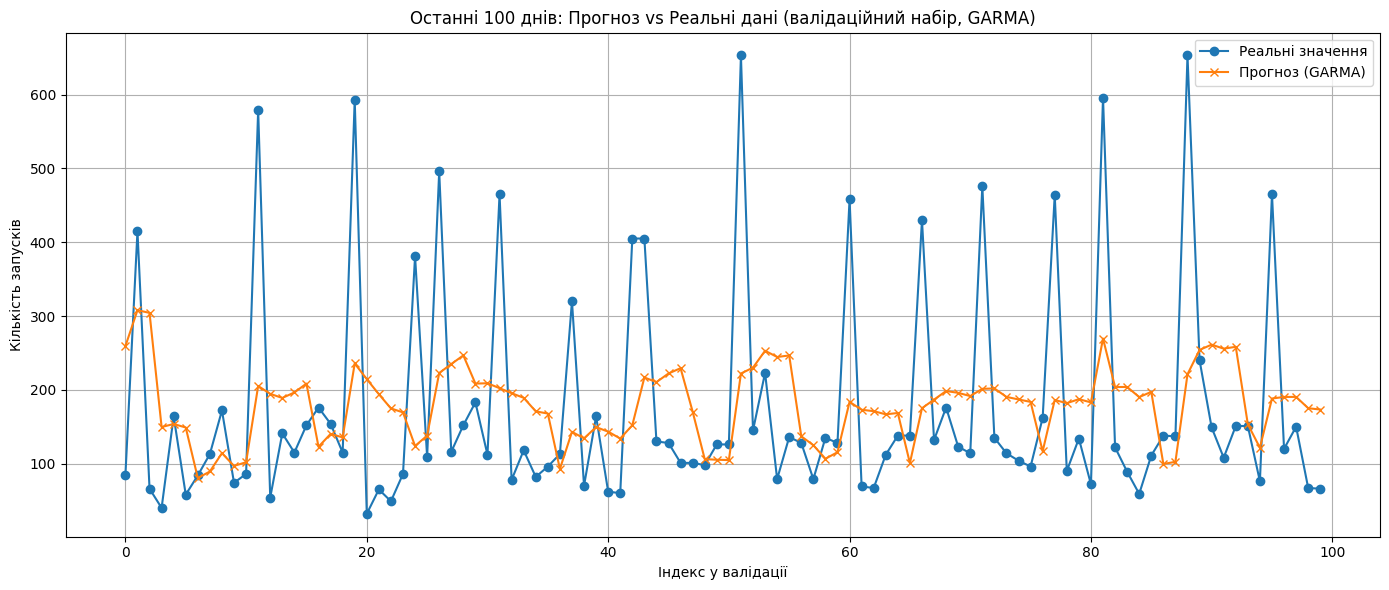

In [110]:
# === Масштабування ознак ===
features = ['launched', 'accumulated_days', 'rolling_mean_5', 'std_5', 'weekday']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_ss[features])

# === Формування датасету для GARMA (використаємо тільки launched + exog) ===
scaled_df = pd.DataFrame(scaled_data, columns=features, index=df_ss.index)

# Цільова змінна
launched_scaled = scaled_df['launched']

# Ознаки (exogenous variables): всі крім launched
exog_vars = scaled_df.drop(columns=['launched'])

# Розбиття на train/val
train_size = int(len(launched_scaled) * 0.3)
endog_train = launched_scaled.iloc[:train_size]
endog_val = launched_scaled.iloc[train_size:]
exog_train = exog_vars.iloc[:train_size]
exog_val = exog_vars.iloc[train_size:]

# === Побудова моделі SARIMAX як заміни GARMA ===
model = SARIMAX(endog_train, exog=exog_train, order=(5, 0, 7), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

# === Прогноз ===
forecast_scaled = results.forecast(steps=len(endog_val), exog=exog_val)

# Зворотне масштабування прогнозу
pred_full = np.hstack([forecast_scaled.values.reshape(-1, 1), np.zeros((len(forecast_scaled), 4))])
y_pred_inverse = scaler.inverse_transform(pred_full)[:, 0]

# Зворотне масштабування реальних значень
true_full = np.hstack([endog_val.values.reshape(-1, 1), np.zeros((len(endog_val), 4))])
y_val_inverse = scaler.inverse_transform(true_full)[:, 0]

# === Оцінка якості ===
mae = mean_absolute_error(y_val_inverse, y_pred_inverse)
rmse = np.sqrt(mean_squared_error(y_val_inverse, y_pred_inverse))

print(f'\nОцінка якості моделі GARMA (SARIMAX):')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

# === Візуалізація ===
# Візуалізація останніх 100 днів валідації
plot_range = 100
y_val_last = y_val_inverse[-plot_range:]
y_pred_last = y_pred_inverse[-plot_range:]

plt.figure(figsize=(14, 6))
plt.plot(y_val_last, label='Реальні значення', marker='o')
plt.plot(y_pred_last, label='Прогноз (GARMA)', marker='x')
plt.title('Останні 100 днів: Прогноз vs Реальні дані (валідаційний набір, GARMA)')

plt.xlabel('Індекс у валідації')
plt.ylabel('Кількість запусків')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#MAE: 49.00 RMSE: 74.01 при order=(5, 0, 5)
#MAE: 50.99 RMSE: 74.86 при order=(5, 1, 5)
#MAE: 48.78 RMSE: 74.02 при order=(5, 0, 7)
#MAE: 23.39 RMSE: 42.78 при train_size = 0.3
#MAE: 22.94 RMSE: 42.19 при train_size = 0.28

In [111]:
#LSTM краще працює з нормалізованими даними, тому:

# === Підготовка ===
scaler = MinMaxScaler()
features = ['launched', 'accumulated_days', 'rolling_mean_5', 'std_5', 'weekday']
scaled_data = scaler.fit_transform(df_ss[features])

In [112]:
# === Формування послідовностей ===
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 0])  # launched (scaled)
    return np.array(X), np.array(y)

window_size = 30

In [113]:
# Використовуємо лише одну ознаку — launched
# Розділення на train/val
train_size = int(len(df_ss) * 0.8)
train_data = df_ss['launched'].iloc[:train_size]
val_data = df_ss['launched'].iloc[train_size:]

In [145]:
print('=============СТАТИСТИКА===============\n')
print("Сума запущених дронів за останній місяць:", total_launched)
print("Сума дронів, що не досягли цілі за останній місяць:", total_intercepted)
print("Ефективність ППО за минулий місяць:", (total_intercepted/total_launched).round(4)*100, '%')
print("Сума запущених дронів за минулий тиждень:", last_week_data['launched'].sum(), '\n')
print('==============РЕКОРДИ================\n')
print(f"Рекордним місяцем за кількістю запусків був {month_name} {year} року і становить {max_value} дронів.")
print(f"Рекордним днем за кількістю запусків було {day_number}-е {month_name_d} {year_d} року і становить {max_value_day} дронів.\n")
print('==============ПРОГНОЗ================\n')
print("Очікувана кількість запущених дронів за місяць (за умови збереження тенденції):", (total_launched/last_month_data.date.max().day*days_in_month).astype(int), '\n') #прогноз від 17.02.2025 на кількість дронів в місяць = 3071

=============СТАТИСТИКА===============

Сума запущених дронів за останній місяць: 2930
Сума дронів, що не досягли цілі за останній місяць: 2338
Ефективність ППО за минулий місяць: 79.80000000000001 %
Сума запущених дронів за минулий тиждень: 1220 

==============РЕКОРДИ================

Рекордним місяцем за кількістю запусків був липень 2025 року і становить 6297 дронів.
Рекордним днем за кількістю запусків було 7-е вересня 2025 року і становить 810 дронів.

==============ПРОГНОЗ================

Очікувана кількість запущених дронів за місяць (за умови збереження тенденції): 5342 



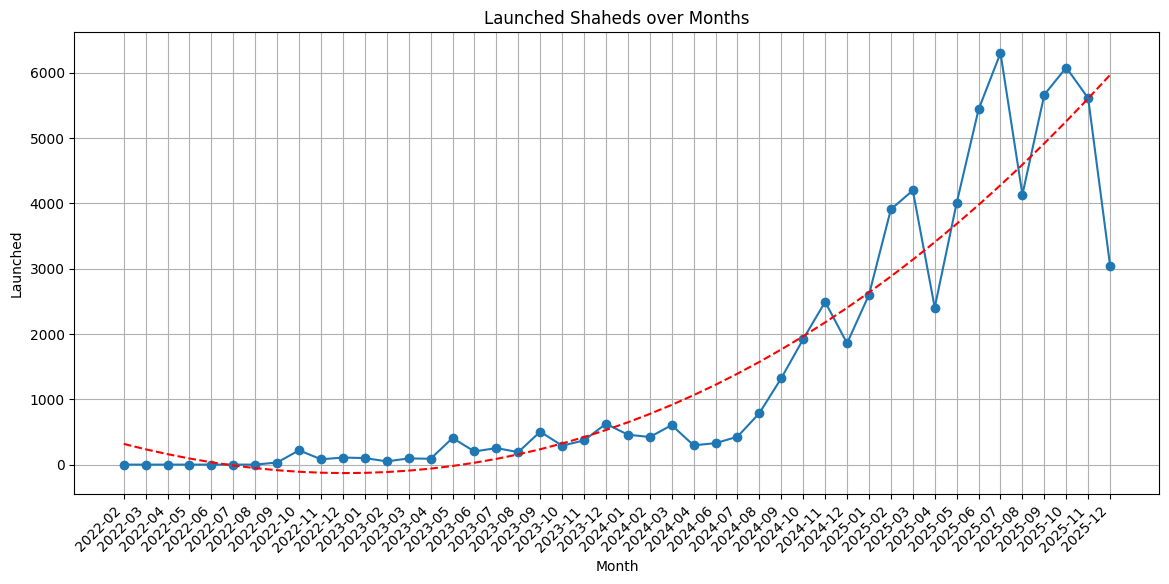

In [115]:
# Видалення рядків, де значення в стовпці 'launched' дорівнює 0
plot_shahed2 = shahed2[shahed2['launched'] != 0]
plot_shahed2 = plot_shahed2.reset_index(drop=True)

# Згрупувати дані по місяцях та обчислити середнє значення 'launched' для кожного місяця
plot_shahed2['month'] = plot_shahed2['date'].dt.to_period('M')
# Групування за місяцями та обчислення суми по стовпцях 'launched' та 'intercepted'
df_grouped = plot_shahed2.groupby('month')[['launched', 'intercepted']].sum().reset_index()
df_grouped['launched'] = df_grouped['launched'].astype(int)
df_grouped['intercepted'] = df_grouped['intercepted'].astype(int)

# Обчислення відсотку перехоплення
df_grouped['interc_perc'] = round((df_grouped['intercepted'] / df_grouped['launched']) * 100, 1)
new_rows_s = pd.DataFrame({'month': ['2022-02', '2022-03','2022-04', '2022-05','2022-06', '2022-07','2022-08'],
                           'launched': [0,0,0,0,0,0,0],
                           'intercepted': [0,0,0,0,0,0,0],
                           'interc_perc': [0,0,0,0,0,0,0],
                           'month_number': [0,0,0,0,0,0,0]})

df_grouped = pd.concat([new_rows_s, df_grouped], ignore_index=True)


# Перерахунок значень month_number
df_grouped['month_number'] = range(1, len(df_grouped) + 1)

# Побудова лінійного графіка
plt.figure(figsize=(14, 6))  # Задаємо розміри графіка
plt.plot(df_grouped['month_number'], df_grouped['launched'], marker='o', linestyle='-')  # Побудова графіка

month_numbers = df_grouped['month_number']
month_dates = df_grouped['month']
plt.xticks(month_numbers, month_dates, rotation=45, ha='right')  # Обертаємо та відображаємо мітки

# Побудова нелінійного тренду (поліном другого степеня)
z = np.polyfit(df_grouped['month_number'], df_grouped['launched'], 3) # ставити 2й степінь полінома (але можна погратись і пошукати інші значення)
p = np.poly1d(z)
plt.plot(df_grouped['month_number'], p(df_grouped['month_number']), "r--")

# Додавання заголовків та підписів до осей
plt.xlabel('Month')
plt.ylabel('Launched')
plt.title('Launched Shaheds over Months')

# Відображення сітки на графіку
plt.grid(True)

# Показ графіка
plt.show()


# Знизу поки що РОБОЧА частина коду з ракетами

In [116]:
# Список URL-ів
urls = [
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%BB%D1%8E%D1%82%D0%B8%D0%B9-%D1%82%D1%80%D0%B0%D0%B2%D0%B5%D0%BD%D1%8C_2022)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D1%87%D0%B5%D1%80%D0%B2%D0%B5%D0%BD%D1%8C-%D1%81%D0%B5%D1%80%D0%BF%D0%B5%D0%BD%D1%8C_2022)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%B2%D0%B5%D1%80%D0%B5%D1%81%D0%B5%D0%BD%D1%8C-%D0%BB%D0%B8%D1%81%D1%82%D0%BE%D0%BF%D0%B0%D0%B4_2022)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%B3%D1%80%D1%83%D0%B4%D0%B5%D0%BD%D1%8C-%D0%BB%D1%8E%D1%82%D0%B8%D0%B9_2023)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%B1%D0%B5%D1%80%D0%B5%D0%B7%D0%B5%D0%BD%D1%8C-%D1%82%D1%80%D0%B0%D0%B2%D0%B5%D0%BD%D1%8C_2023)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D1%87%D0%B5%D1%80%D0%B2%D0%B5%D0%BD%D1%8C-%D1%81%D0%B5%D1%80%D0%BF%D0%B5%D0%BD%D1%8C_2023)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%B7_%D0%B2%D0%B5%D1%80%D0%B5%D1%81%D0%BD%D1%8F_2023)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%B7%D0%B8%D0%BC%D0%B0_2023/2024)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%B2%D0%B5%D1%81%D0%BD%D0%B0_2024)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%BB%D1%96%D1%82%D0%BE_2024)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%BE%D1%81%D1%96%D0%BD%D1%8C_2024)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%B7%D0%B8%D0%BC%D0%B0_2024/2025)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%B2%D0%B5%D1%81%D0%BD%D0%B0_2025)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%BB%D1%96%D1%82%D0%BE_2025)',
    'https://uk.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BB%D1%96%D0%BA_%D1%80%D0%B0%D0%BA%D0%B5%D1%82%D0%BD%D0%B8%D1%85_%D1%83%D0%B4%D0%B0%D1%80%D1%96%D0%B2_%D0%BF%D1%96%D0%B4_%D1%87%D0%B0%D1%81_%D1%80%D0%BE%D1%81%D1%96%D0%B9%D1%81%D1%8C%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B2%D1%82%D0%BE%D1%80%D0%B3%D0%BD%D0%B5%D0%BD%D0%BD%D1%8F_(%D0%BE%D1%81%D1%96%D0%BD%D1%8C_2025)',
    # Додайте інші URL-и за потреби
]

# Створення списку для об'єктів BeautifulSoup та HTTP-запитів
responses = []
soups = []

# Виконання HTTP-запитів та створення об'єктів BeautifulSoup
for url in urls:
    response = requests.get(url)
    responses.append(response)
    soups.append(BeautifulSoup(response.text, 'html.parser'))

# Чистка таблиць від дублікатів за допомогою регулярних виразів
def clean_table(table_html):
    table_str = str(table_html)
    cleaned_table = re.sub(r'<td\s+(colspan="\d+"\s+)?rowspan="\d+">(\d+)/(\d+)(\n</td>)?', r'<td>\2/\3\4</td>', table_str)
    cleaned_table = re.sub(r'<td\s+rowspan="\d+">(\d+)/(\d+)\n</td>', r'<td>\1/\2\n</td>', cleaned_table)
    cleaned_table = re.sub(r'<td\s+rowspan="\d+">(\d+)/(\d+)', r'<td>\1/\2', cleaned_table)

    df = pd.read_html(cleaned_table)[0]
    return df


HEADERS = {
    "User-Agent": "Mozilla/5.0"
}

# Функція для отримання DataFrame з вмісту таблиці
def get_dataframe(url):
    response = requests.get(url, headers=HEADERS)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all('table', class_=lambda c: c and 'wikitable' in c)

    # Вибираємо таблиці з індексами 1, 2, 3 та 4, якщо вони доступні
    if len(tables) >= 4:
        cleaned_tables = [clean_table(tables[i]) for i in range(1, min(5, len(tables)))]
    elif len(tables) >= 3:
        cleaned_tables = [clean_table(tables[i]) for i in range(1, min(4, len(tables)))]
    else:
        cleaned_tables = [clean_table(tables[1])]  # Якщо немає таблиць з індексами 2, 3 або 4, то вибираємо тільки таблицю з індексом 1

    return cleaned_tables

# Отримання даних для кожного URL-у та створення DataFrame
dataframes = [get_dataframe(url) for url in urls]

# Об'єднання кожного списку DataFrame у свій власний DataFrame
df_m = pd.concat([df for df_list in dataframes for df in df_list], ignore_index=True)

In [117]:
# Об'єднання усіх DataFrame усередині списку
#df_m = pd.concat(concatenated_dataframes, ignore_index=True)

df_m.columns = df_m.columns.droplevel(0)
df_m = df_m.reset_index()
df_m.columns.values[0:5] = 'Нова_назва'
df_m = df_m.drop(['Нова_назва'], axis=1)
df_m.columns.values[2] = 'Нова_назва'
df_m = df_m.drop(['Нова_назва'], axis=1)
df_m.columns.values[3] = 'тип ракети'
df_m.columns.values[4] = 'подробиці'

# Фільтрація даних
df_m = df_m.loc[df_m['дата'] != 'дата не встановлена']
df_m = df_m.dropna(subset=df_m.columns[1:6], how='all')
df_m = df_m.reset_index()
df_m = df_m.drop(['index'], axis=1)

# Копіювання даних зі стовпчика 9 в стовпчик 3 (рядки 670-733)
df_m.iloc[689:732, 3] = df_m.iloc[689:732, 9]
df_m.iloc[956:981, 1] = df_m.iloc[956:981, 11]
df_m.iloc[1078:1175, 1] = df_m.iloc[1078:1175, 11]
df_m.iloc[1078:1175, 4] = df_m.iloc[1078:1175, 12]

df_m = df_m.reset_index()
df_m = df_m.drop(['index'], axis=1)

df_m.columns.values[5:14] = 'Нова_назва'
df_m = df_m.drop(['Нова_назва'], axis=1)

df_m['подробиці'] = df_m['подробиці'].str.replace(r'\[\d+\]', '', regex=True)
df_m['ракети'] = df_m['ракети'].str.replace(r'\[\d+\]', '', regex=True)
df_m['регіон'] = df_m['регіон'].str.replace(r'\[\d+\]', '', regex=True)
df_m['тип ракети'] = df_m['тип ракети'].str.replace(r'\[\d+\]', '', regex=True)

df_m = df_m.dropna(subset=df_m.columns[1:6], how='all')
df_m = df_m.drop(df_m.loc[df_m['ракети'] == '—'].index)
df_m = df_m.reset_index(drop=True)

# Переконайся, що стовпчик 'дата' має формат datetime
df_m['дата'] = pd.to_datetime(df_m['дата'], dayfirst=True, errors='coerce')

# Маска для дат після 1 березня 2025 року
mask = df_m['дата'] > pd.Timestamp('2025-03-01')

# Тимчасово зберігаємо значення
temp = df_m.loc[mask, 'ракети'].copy()
df_m.loc[mask, 'ракети'] = df_m.loc[mask, 'тип ракети']
df_m.loc[mask, 'тип ракети'] = temp

df_m

,дата,регіон,ракети,тип ракети,подробиці
0,2022-02-24,Львівська обл.,0/3,Калібр,"військова інфраструктура, жертви: 0/1"
1,2022-02-24,Львівська обл.,0/2+,Калібр,"військова інфраструктура, жертви: 0/1"
2,2022-02-24,Львівська обл.,0/5,Калібр,"військова інфраструктура, жертви: 0/1"
3,2022-02-24,Івано-Франківська обл.,0/4,Калібр,склад ПММ
4,2022-02-24,Івано-Франківська обл.,0/2,Калібр,"військовий аеродром, жертви: 0/5"
...,...,...,...,...,...
1637,2025-11-25,"РФ, Новоросійськ",1/1,Калібр,ракета передчасно вибухнула
1638,2025-11-26,Україна,0/2,Іскандер-М,не встановлено
1639,2025-11-26,Харківська обл.,не встановлено,Іскандер-М,NaN
1640,2025-11-28,Україна,0/1,Іскандер-М,не встановлено


In [118]:
# спочатку перейменовувати, потім видаляти
df_m.iat[170,2] = '1/3'
df_m.iat[418,1] = 'Україна'
df_m.iat[452,1] = 'Україна'
df_m.iat[458,1] = 'Центр, Північ'
df_m.iat[486,1] = 'Центр, Захід'
df_m.iat[500,0] = '29.01.2023'
df_m.iat[501,0] = '29.01.2023'
df_m.iat[502,0] = '29.01.2023'
df_m.iat[505,1] = 'Україна'
df_m.iat[511,1] = 'Центр, Захід'
df_m.iat[521,0] = '15.02.2023'
df_m.iat[528,1] = 'Україна'
df_m.iat[593,1] = 'Центр, Схід'
df_m.iat[647,2] = '1/3'
df_m.iat[659,1] = 'Захід'
df_m.iat[679,1] = 'Київ, Черкаси, Захід'
df_m.iat[695,1] = 'Південь'
df_m.iat[786,1] = 'Центр, Північ'
df_m.iat[797,2] = '1/3'
df_m.iat[799,1] = 'Центр, Північ'
df_m.iat[818,1] = 'Україна'
df_m.iat[828,1] = 'Україна'
df_m.iat[901,1] = 'Україна'
df_m.iat[909,1] = 'Київ, Львів'
df_m.iat[950,1] = 'Україна'

# Виберемо рядки, які починаються на "число/число"
mask = df_m['ракети'].str.match(r'^\d+/\d+')

# Застосуємо маску до DataFrame, щоб залишити тільки відповідні рядки
df_m = df_m[mask.astype(bool)]
df_m = df_m.reset_index(drop=True)
df_m

,дата,регіон,ракети,тип ракети,подробиці
0,2022-02-24,Львівська обл.,0/3,Калібр,"військова інфраструктура, жертви: 0/1"
1,2022-02-24,Львівська обл.,0/2+,Калібр,"військова інфраструктура, жертви: 0/1"
2,2022-02-24,Львівська обл.,0/5,Калібр,"військова інфраструктура, жертви: 0/1"
3,2022-02-24,Івано-Франківська обл.,0/4,Калібр,склад ПММ
4,2022-02-24,Івано-Франківська обл.,0/2,Калібр,"військовий аеродром, жертви: 0/5"
...,...,...,...,...,...
1432,2025-11-22,Україна,0/1,Іскандер-М,не встановлено
1433,2025-11-25,"РФ, Новоросійськ",1/1,Калібр,ракета передчасно вибухнула
1434,2025-11-26,Україна,0/2,Іскандер-М,не встановлено
1435,2025-11-28,Україна,0/1,Іскандер-М,не встановлено


***ВРУЧНУ ДОДАЮ ВІДОМОСТІ ПО АТАКАХ, ДЛЯ ЯКИХ НЕМАЄ КОНКРЕТИКИ***

In [119]:
#відповідно до даних у ВІКІ
new_rows_m = pd.DataFrame({'дата': ['24.02.2022','31.03.2022','30.04.2022','31.05.2022','30.06.2022','31.07.2022','31.08.2022','30.09.2022','31.10.2022','30.11.2022','31.12.2022','31.01.2023','28.02.2023','31.03.2023','30.04.2023'],
                         'регіон': ['Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна','Україна'],
                         'ракети': ['0/31','1/51','3/32','2/24','1/22','0/19','0/17','0/21','0/0','0/0','0/0','0/0','0/2','0/7','0/3'],
                         'тип ракети': ['—','—','—','—','—','—','—','—','—','—','—','—','—','—','—'],
                         'подробиці': ['—','—','—','—','—','—','—','—','—','—','—','—','—','—','—']})
# Вставка нових рядків для квітня 2023 відповідно до даних у ВІКІ
df_m = pd.concat([df_m, new_rows_m])

df_m['дата'] = df_m['дата'].fillna(method = 'ffill')
#df_m['дата'] = df_m['дата'].str.replace('\?\?.\?\?.2022', '15.04.2022', regex=True)  # або ж просто видаліть рядок, бо тут нуль інформативної складової
#df_m['дата'] = df_m['дата'].str.replace('\?\?', '15', regex=True)  # нехай усі випадки, коли точна дата атаки невідома, це буде 15-им числом місяця
df_m['дата'] = pd.to_datetime(df_m['дата'], format='%d.%m.%Y')

df_m = df_m.sort_values(by='дата')
df_m.reset_index(drop=True, inplace=True)

df_m

,дата,регіон,ракети,тип ракети,подробиці
0,2022-02-24,Львівська обл.,0/3,Калібр,"військова інфраструктура, жертви: 0/1"
1,2022-02-24,Донецька обл.,0/1,Точка-У,не встановлено
2,2022-02-24,Донецька обл.,0/1,Точка-У,"лікарня, жертви: 4/10"
3,2022-02-24,Харківська обл.,0/1,—,"цивільна інфраструктура, жертви: 2/2"
4,2022-02-24,Дніпропетровська обл.,0/1,—,"інфраструктура аеропорту, жертви: 0/0"
...,...,...,...,...,...
1447,2025-11-22,Україна,0/1,Іскандер-М,не встановлено
1448,2025-11-25,"РФ, Новоросійськ",1/1,Калібр,ракета передчасно вибухнула
1449,2025-11-26,Україна,0/2,Іскандер-М,не встановлено
1450,2025-11-28,Україна,0/1,Іскандер-М,не встановлено


In [120]:
missiles = df_m
# Розділення стовпця на два окремі стовпчики
missiles[['перехоплено', 'запущено']] = missiles['ракети'].str.split('/', expand=True)

# Вибираємо стовпці за їхніми позиціями
column_6 = missiles.iloc[:, 5]
column_7 = missiles.iloc[:, 6]

# Видаляємо стовпчик на позиції 4
missiles.drop(columns=['ракети'], inplace=True)
missiles.drop(columns=['перехоплено'], inplace=True)
missiles.drop(columns=['запущено'], inplace=True)

# Вставляємо стовпці на нові позиції
missiles.insert(loc=2, column='перехоплено', value=column_6)
missiles.insert(loc=3, column='запущено', value=column_7)

missiles_test = missiles
missiles_test

,дата,регіон,перехоплено,запущено,тип ракети,подробиці
0,2022-02-24,Львівська обл.,0,3,Калібр,"військова інфраструктура, жертви: 0/1"
1,2022-02-24,Донецька обл.,0,1,Точка-У,не встановлено
2,2022-02-24,Донецька обл.,0,1,Точка-У,"лікарня, жертви: 4/10"
3,2022-02-24,Харківська обл.,0,1,—,"цивільна інфраструктура, жертви: 2/2"
4,2022-02-24,Дніпропетровська обл.,0,1,—,"інфраструктура аеропорту, жертви: 0/0"
...,...,...,...,...,...,...
1447,2025-11-22,Україна,0,1,Іскандер-М,не встановлено
1448,2025-11-25,"РФ, Новоросійськ",1,1,Калібр,ракета передчасно вибухнула
1449,2025-11-26,Україна,0,2,Іскандер-М,не встановлено
1450,2025-11-28,Україна,0,1,Іскандер-М,не встановлено


In [121]:
#тестовий кусок для виведення не числових значень у стовпчику ()
#missiles['intercepted_numeric'] = pd.to_numeric(missiles['intercepted'], errors='coerce')
#non_numeric_rows = missiles[missiles['intercepted_numeric'].isna()]
#print(non_numeric_rows)

In [122]:
missiles = missiles_test
missiles = missiles.rename(columns = {'дата': 'date', 'регіон':'region', 'перехоплено':'intercepted', 'запущено':'launched', 'тип ракети':'missile_type', 'подробиці':'hits_and_casulties'})

missiles.region = missiles.region.fillna(method = 'ffill')
missiles.region = missiles.region.fillna('Невідомо')
missiles.missile_type = missiles.missile_type.replace({'—':'Невстановл.'})
missiles.intercepted = missiles.intercepted.replace({'':'0/0'})

missiles[['details', 'casualties']] = missiles['hits_and_casulties'].str.split(pat=':', n=1, expand=True)
missiles = missiles.drop('hits_and_casulties', axis=1)
missiles.details = missiles.details.fillna('не встановлено')
missiles.casualties = missiles.casualties.fillna('даних про жертв немає')
missiles.missile_type = missiles.missile_type.fillna('не встановлено')

missiles.intercepted = missiles.intercepted.fillna(0)
missiles['intercepted'] = missiles['intercepted'].replace('0', 0)
missiles['intercepted'] = missiles['intercepted'].replace('—', 0)

missiles['region'] = missiles['region'].str.replace('область', 'обл.')
missiles['region'] = missiles['region'].str.replace('південь', 'Південь')
missiles['region'] = missiles['region'].str.replace('не встановлено', 'Україна')
missiles['region'] = missiles['region'].str.replace('Суми', 'Сумська обл.')
missiles['region'] = missiles['region'].str.replace(r'схід', 'Схід', regex=True)
missiles['launched'] = missiles['launched'].str.replace('+', '', regex=False)


missiles['missile_type'] = missiles['missile_type'].str.replace(r'не встановлено|0/5|авіаудар', 'невстановлений тип ракети', regex=True)
missiles['missile_type'] = missiles['missile_type'].str.replace(r'48Н6ДМ|48Н6', 'С-300', regex=True)
#missiles['missile_type'] = missiles['missile_type'].str.replace(r'\s', '', regex=True)
missiles['missile_type'] = missiles['missile_type'].str.replace(r'Х-101*', 'Х-101/Х-555/Х-55')

missiles['details'] = missiles['details'].str.replace(r'^\s+', '', regex=True)
missiles['details'] = missiles['details'].str.replace(r'\xa0', ' ', regex=True)

missiles.drop(columns=['casualties'], inplace=True)

missiles = missiles.reset_index(drop=True)

missiles['intercepted'] = missiles['intercepted'].astype(int)

################################################################################
missiles['launched'] = missiles['launched'].astype(str)

def replace_plus(match):
    number = int(match.group(1))
    return str(number + 1)

# Застосування регулярного виразу до стовпця
missiles['launched'] = missiles['launched'].apply(lambda x: re.sub(r'(\d+)\+', replace_plus, x))
missiles['launched'] = missiles['launched'].str.replace(r'None', '0')
################################################################################


missiles['launched'] = pd.to_numeric(missiles['launched'], errors='coerce')
missiles['launched'] = missiles['launched'].fillna(0).astype('Int64')

#missiles['intercepted'].value_counts()
#missiles.loc[missiles['intercepted'] == '2 влучання на територію аеродрому, жертви: 0']

#missiles.to_csv('/content/drive/MyDrive/Colab Notebooks/missiles_updated.csv',  encoding='utf-8', index = False)


#missiles.iloc[700:750]
#missiles.missile_type.value_counts()
#missiles.launched.sum()
#missiles.loc[missiles['date'] == '14.04.2023']

#missiles.loc[missiles['missile_type'] == 'Х-29ТД']
missiles.head(10000)

,date,region,intercepted,launched,missile_type,details
0,2022-02-24,Львівська обл.,0,3,Калібр,"військова інфраструктура, жертви"
1,2022-02-24,Донецька обл.,0,1,Точка-У,не встановлено
2,2022-02-24,Донецька обл.,0,1,Точка-У,"лікарня, жертви"
3,2022-02-24,Харківська обл.,0,1,Невстановл.,"цивільна інфраструктура, жертви"
4,2022-02-24,Дніпропетровська обл.,0,1,Невстановл.,"інфраструктура аеропорту, жертви"
...,...,...,...,...,...,...
1447,2025-11-22,Україна,0,1,Іскандер-М,не встановлено
1448,2025-11-25,"РФ, Новоросійськ",1,1,Калібр,ракета передчасно вибухнула
1449,2025-11-26,Україна,0,2,Іскандер-М,не встановлено
1450,2025-11-28,Україна,0,1,Іскандер-М,не встановлено


In [123]:
#missiles.loc[missiles.details == 'українська ППО знищила 29 із 30 ракет та задіяних в атаці']
#missiles.groupby('region').launched.sum().sort_values(ascending = False)
#missiles.head(30)
#missiles.loc[missiles['missile_type'] == 'Р-37']
#missiles.head(14564564)

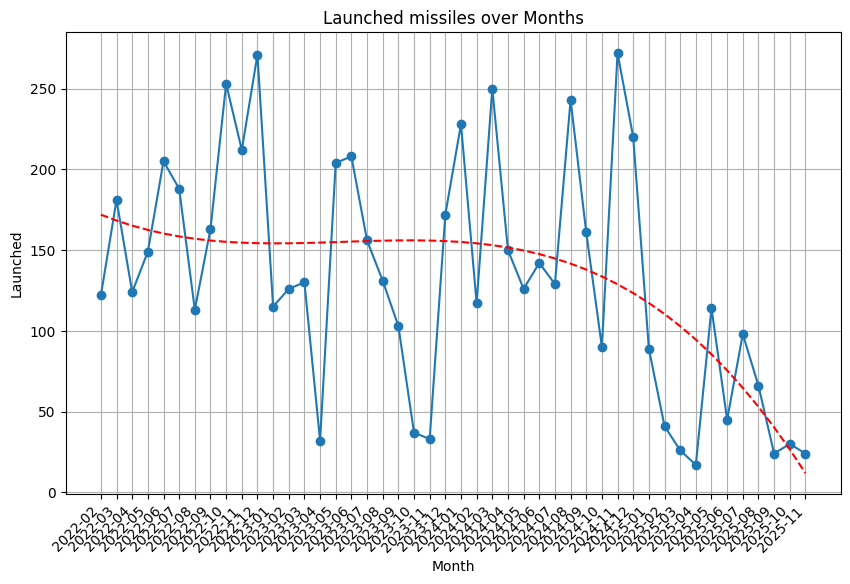

In [124]:
# Видалення рядків, де значення в стовпці 'launched' дорівнює 0
plot_missiles = missiles[missiles['launched'] != 0]
plot_missiles = plot_missiles.reset_index(drop=True)

# Згрупувати дані по місяцях та обчислити середнє значення 'launched' для кожного місяця
plot_missiles['month'] = plot_missiles['date'].dt.to_period('M')
# Групування за місяцями та обчислення суми по стовпцях 'launched' та 'intercepted'
df_grouped_m = plot_missiles.groupby('month')[['launched', 'intercepted']].sum().reset_index()
df_grouped_m['launched'] = df_grouped_m['launched'].astype(int)
df_grouped_m['intercepted'] = df_grouped_m['intercepted'].astype(int)

# Обчислення відсотку перехоплення
df_grouped_m['interc_perc'] = round((df_grouped_m['intercepted'] / df_grouped_m['launched']) * 100, 1)
df_grouped_m['month_number'] = range(1, len(df_grouped_m) + 1)

#df_grouped_m = df_grouped_m.drop(df_grouped_m.index[-1]) #видалення останнього місяця

# Побудова лінійного графіка
plt.figure(figsize=(10, 6))  # Задаємо розміри графіка
plt.plot(df_grouped_m['month_number'], df_grouped_m['launched'], marker='o', linestyle='-')  # Побудова графіка

month_numbers_m = df_grouped_m['month_number']  # Всі номери місяців
month_dates_m = df_grouped_m['month']  # Всі дати місяців
plt.xticks(month_numbers_m, month_dates_m, rotation=45, ha='right')  # Відображаємо мітки

# Побудова нелінійного тренду (поліном другого степеня)
z_m = np.polyfit(df_grouped_m['month_number'], df_grouped_m['launched'], 3)
p_m = np.poly1d(z_m)
plt.plot(df_grouped_m['month_number'], p_m(df_grouped_m['month_number']), "r--")

# Додавання заголовків та підписів до осей
plt.xlabel('Month')
plt.ylabel('Launched')
plt.title('Launched missiles over Months')

# Відображення сітки на графіку
plt.grid(True)

In [125]:
#missiles.loc[missiles['date'] == '2022-12-16']
#a.launched.sum()

In [126]:
missiles.date.value_counts()
missiles_2022 = missiles.loc[missiles['date'] <= '2022-12-31']
missiles_2023 = missiles.loc[(missiles['date'] > '2022-12-31') & (missiles['date'] <= '2023-12-31')]
missiles_2024 = missiles.loc[(missiles['date'] > '2023-12-31') & (missiles['date'] <= '2024-12-31')]
missiles_2025 = missiles.loc[missiles['date'] > '2024-12-31']

In [127]:
missiles.date.value_counts()
a_2022_n = missiles_2022.groupby('region')[['launched', 'intercepted']].sum()
a_2022_n['interc_perc'] = round(((a_2022_n.intercepted / a_2022_n.launched)*100), 1)
a_2022_n.fillna(0, inplace=True)
a_2022_n.sort_values(by = 'launched', ascending = False, inplace = True)

b_2022_n = round(((a_2022_n.intercepted.sum()) / (a_2022_n.launched.sum()) *100), 1)
print('Сили ППО України протягом 2022 року перехопили близько', b_2022_n, '% ворожих ракет.\n')

#a_2022_n.head(20)

Сили ППО України протягом 2022 року перехопили близько 38.3 % ворожих ракет.



In [128]:
a_2023 = missiles_2023.groupby('region')[['launched', 'intercepted']].sum()
a_2023['interc_perc'] = round(((a_2023.intercepted / a_2023.launched)*100), 1)
a_2023.fillna(0, inplace=True)
a_2023.sort_values(by = 'launched', ascending = False, inplace = True)

b_2023 = round(((a_2023.intercepted.sum()) / (a_2023.launched.sum()) *100), 1)
print('Сили ППО України протягом 2023 року перехопили близько', b_2023, '% ворожих ракет.\n')

#a_2023.head(20)

Сили ППО України протягом 2023 року перехопили близько 68.6 % ворожих ракет.



In [129]:
a_2024 = missiles_2024.groupby('region')[['launched', 'intercepted']].sum()
a_2024['interc_perc'] = round(((a_2024.intercepted / a_2024.launched)*100), 1)
a_2024.fillna(0, inplace=True)
a_2024.sort_values(by = 'launched', ascending = False, inplace = True)

b_2024 = round(((a_2024.intercepted.sum()) / (a_2024.launched.sum()) *100), 1)
print('Сили ППО України протягом 2024 року перехопили близько', b_2024, '% ворожих ракет.\n')

#a_2024.head(20)

Сили ППО України протягом 2024 року перехопили близько 57.9 % ворожих ракет.



In [130]:
a_2025 = missiles_2025.groupby('region')[['launched', 'intercepted']].sum()
a_2025['interc_perc'] = round(((a_2025.intercepted / a_2025.launched)*100), 1)
a_2025.fillna(0, inplace=True)
a_2025.sort_values(by = 'launched', ascending = False, inplace = True)

b_2025 = round(((a_2025.intercepted.sum()) / (a_2025.launched.sum()) *100), 1)
print('Сили ППО України протягом 2024 року перехопили близько', b_2025, '% ворожих ракет.\n')

#a_2025.head(20)

Сили ППО України протягом 2024 року перехопили близько 45.5 % ворожих ракет.



In [131]:
a = missiles.groupby('region')[['launched', 'intercepted']].sum()
a['interc_perc'] = round(((a.intercepted / a.launched)*100), 2)
a.fillna(0, inplace=True)
a.sort_values(by = 'launched', ascending = False, inplace = True)

b = round(((a.intercepted.sum()) / (a.launched.sum()) *100), 2)
print('З початку повномасштабного вторгнення засобами ППО України було перехоплено близько', b, '% ворожих ракет.\n')
a.launched.sum()
#a.head(20)

З початку повномасштабного вторгнення засобами ППО України було перехоплено близько 52.92 % ворожих ракет.



np.int64(6130)

In [132]:
aggregated_t = missiles[missiles['missile_type'].str.contains('Х-101')].reset_index(drop=True)
aggregated_t = aggregated_t.groupby(['date'])[['region', 'intercepted',	'launched',	'missile_type',	'details']].agg(list).reset_index()

# Функція для розбиття списків на множини та об'єднання множин у рядок
def unique_values_to_string(unique_list):
    return ', '.join(sorted(unique_list))

aggregated_t['region'] = aggregated_t['region'].apply(lambda x: unique_values_to_string(set(x)))
aggregated_t['intercepted'] = aggregated_t['intercepted'].replace(r'([^0-9\.]),|,([^0-9])', r'\1\2', regex=True)
aggregated_t['intercepted'] = aggregated_t['intercepted'].replace(r', \[\s*\]$|0,|\[|\]', '', regex=True)
aggregated_t['launched'] = aggregated_t['launched'].replace('([^0-9]),', value=r'\1', regex=True)
aggregated_t['launched'] = aggregated_t['launched'].replace(r'\[|\]', '', regex=True)
aggregated_t['missile_type'] = aggregated_t['missile_type'].apply(lambda x: unique_values_to_string(set(x)))
aggregated_t['details'] = aggregated_t['details'].apply(lambda x: unique_values_to_string(set(x)))
aggregated_t['details'] = aggregated_t['details'].replace(r'^не встановлено, |жертви', r'', regex=True)
aggregated_t['details'] = aggregated_t['details'].replace(r',\s+,', r',', regex=True)
aggregated_t['details'] = aggregated_t['details'].replace(r'^не встановлено,', r'не встановлено', regex=True)

def replace_with_sum(numbers):
    return str(sum(numbers))

aggregated_t['intercepted'] = aggregated_t['intercepted'].apply(replace_with_sum).astype(int)
aggregated_t['launched'] = aggregated_t['launched'].apply(replace_with_sum).astype(int)

aggregated_t['interc_perc'] = round(((aggregated_t.intercepted / aggregated_t.launched)*100), 1)
aggregated_t = aggregated_t.drop(['region', 'details'], axis=1)

aggregated_t

,date,intercepted,launched,missile_type,interc_perc
0,2022-04-23,2,4,Х-101/Х-555/Х-55,50.0
1,2022-05-07,0,6,Х-101/Х-555/Х-55,0.0
2,2022-06-26,1,6,Х-101/Х-555/Х-55,16.7
3,2022-07-15,4,8,Х-101/Х-555/Х-55,50.0
4,2022-07-16,0,1,Х-101/Х-555/Х-55,0.0
...,...,...,...,...,...
89,2025-07-12,25,26,Х-101,96.2
90,2025-07-19,30,35,"Іскандер-К, Х-101",85.7
91,2025-07-27,2,4,Х-101,50.0
92,2025-08-19,6,10,"Іскандер-М, Х-101",60.0


In [133]:
aggregated_t.intercepted.sum()

np.int64(1756)

**Код нижче суто для того шоб поженити 2 таблиці з індексацією по даті (де вона буде унікальною)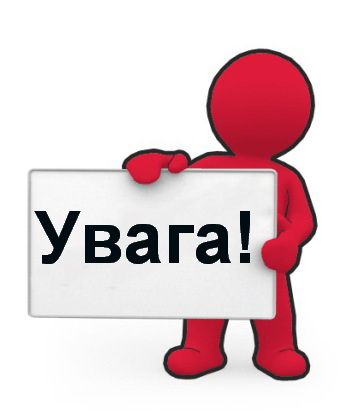**

In [134]:
missiles.set_index('date', inplace=True)

In [135]:
aggregated_df = missiles.groupby(['date'])[['region', 'intercepted',	'launched',	'missile_type',	'details']].agg(list).reset_index()

aggregated_df['intercepted'] = aggregated_df['intercepted'].astype(str)
aggregated_df['launched'] = aggregated_df['launched'].astype(str)

# Функція для розбиття списків на множини та об'єднання множин у рядок
def unique_values_to_string(unique_list):
    return ', '.join(sorted(unique_list))

aggregated_df['region'].fillna('', inplace=True)
aggregated_df['intercepted'].fillna('', inplace=True)
aggregated_df['launched'].fillna('', inplace=True)
aggregated_df['missile_type'].fillna('', inplace=True)
aggregated_df['details'].fillna('', inplace=True)

# Застосуємо функцію до кожного стовпчика
aggregated_df['region'] = aggregated_df['region'].apply(lambda x: unique_values_to_string(set(x)))

aggregated_df['intercepted'] = aggregated_df['intercepted'].replace(r'([^0-9\.]),|,([^0-9])', r'\1\2', regex=True)
aggregated_df['intercepted'] = aggregated_df['intercepted'].replace(r', \[\s*\]$|0,|\[|\]', '', regex=True)

aggregated_df['launched'] = aggregated_df['launched'].replace('([^0-9]),', value=r'\1', regex=True)
aggregated_df['launched'] = aggregated_df['launched'].replace(r'\[|\]', '', regex=True)

aggregated_df['missile_type'] = aggregated_df['missile_type'].apply(lambda x: unique_values_to_string(set(x)))
aggregated_df['details'] = aggregated_df['details'].apply(lambda x: unique_values_to_string(set(x)))

aggregated_df['details'] = aggregated_df['details'].replace(r'^не встановлено, |жертви', r'', regex=True)
aggregated_df['details'] = aggregated_df['details'].replace(r',\s+,', r',', regex=True)
aggregated_df['details'] = aggregated_df['details'].replace(r'^не встановлено,', r'не встановлено', regex=True)

def replace_with_sum(text):
    # Знаходимо всі числа у тексті
    numbers = [int(num) for num in re.findall(r'\d+', text)]
    # Замінюємо числа на їхню суму
    return str(sum(numbers))

aggregated_df['intercepted'] = aggregated_df['intercepted'].apply(replace_with_sum)
aggregated_df['launched'] = aggregated_df['launched'].apply(replace_with_sum)


missiles_agg = aggregated_df

missiles_agg['intercepted'] = missiles_agg['intercepted'].astype(int)
missiles_agg['launched'] = missiles_agg['launched'].fillna(0).astype(int)

#missiles_agg.launched.sum()
#missiles_agg.head(208)
#missiles_agg.details.value_counts()
missiles_agg

,date,region,intercepted,launched,missile_type,details
0,2022-02-24,"Івано-Франківська обл., Волинська обл., Дніпро...",1,1417,"Калібр, Невстановл., Точка-У, Х-31","військова інфраструктура, військова інфраструк..."
1,2022-02-25,"Київ, Київська обл., Полтавська обл., Рівненсь...",1,395,"Іскандер, Калібр, Невстановл.","Т-64БВ, БМП-1, аеропорт«Рівне», військовий аер..."
2,2022-02-26,"Житомирська обл., Київ, Сумська обл., Хмельниц...",5,400,Невстановл.,"військова інфраструктура, військовий аеродром,..."
3,2022-02-27,"Житомирська обл., Київ",1,130,"Іскандер, Невстановл.","аеропорт «Житомир», перехоплено українською ППО"
4,2022-02-28,"Київ, Київська обл., Харківська обл.",0,276,"Іскандер, Невстановл.","військова інфраструктура, не встановлено, циві..."
...,...,...,...,...,...,...
795,2025-11-22,Україна,0,65,Іскандер-М,не встановлено
796,2025-11-25,"РФ, Новоросійськ",1,65,Калібр,ракета передчасно вибухнула
797,2025-11-26,Україна,0,66,Іскандер-М,не встановлено
798,2025-11-28,Україна,0,65,Іскандер-М,не встановлено


**КОД ДЛЯ ПЕРЕВІРКИ КІЛЬКОСТІ РАКЕТ ПО МІСЯЦЯХ**

In [136]:
from datetime import datetime, timedelta

# Початкова та кінцева дати
start_date = datetime(2022, 2, 24)
end_date = datetime(2024, 5, 14)

# Створення списку дат починаючи з початкової дати і закінчуючи кінцевою датою
dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date)
    current_date += timedelta(days=1)

# Розділення дат на місяці
month_ranges = []
current_month = dates[0].month
start_index = 0
for i, date in enumerate(dates):
    if date.month != current_month:
        month_ranges.append((dates[start_index], dates[i-1]))
        start_index = i
        current_month = date.month
month_ranges.append((dates[start_index], dates[-1]))

# Створення підсумкового DataFrame для місяців
month_summary = pd.DataFrame(columns=['Місяць', 'launched', 'intercepted'])

# Розрахунок суми ракет "launched" та "intercepted" для кожного місяця
for month, (start_date, end_date) in enumerate(month_ranges, start=1):
    month_data = missiles_agg[(missiles_agg['date'] >= start_date) & (missiles_agg['date'] <= end_date)]
    sum_launched = month_data['launched'].sum()
    sum_intercepted = month_data['intercepted'].sum()
    month_summary = pd.concat([month_summary, pd.DataFrame({'Місяць': [month], 'launched': [sum_launched], 'intercepted': [sum_intercepted]})], ignore_index=True)

#print(month_summary)


In [137]:
n_missiles_agg = missiles_agg.rename(columns = {'intercepted':'missiles_intercepted', 'launched':'missiles_launched', 'missile_type':'weapon_type'})
n_shahed_agg = shahed_agg.rename(columns = {'intercepted':'shaheds_intercepted', 'launched':'shaheds_launched', 'missile_type':'weapon_type'})
combined_df = pd.concat([n_missiles_agg, n_shahed_agg], ignore_index=True)

# Вибираємо стовпці за їхніми позиціями
column_6 = combined_df.iloc[:, 6]
column_7 = combined_df.iloc[:, 7]

# Видаляємо стовпчик на позиції 4
combined_df.drop(columns=['shaheds_intercepted'], inplace=True)
combined_df.drop(columns=['shaheds_launched'], inplace=True)

# Вставляємо стовпці на нові позиції
combined_df.insert(loc=3, column='shaheds_intercepted', value=column_6)
combined_df.insert(loc=5, column='shaheds_launched', value=column_7)

combined_df['missiles_intercepted'] = combined_df['missiles_intercepted'].fillna(0).astype(int)
combined_df['missiles_launched'] = combined_df['missiles_launched'].fillna(0).astype(int)
combined_df['shaheds_intercepted'] = combined_df['shaheds_intercepted'].fillna(0).astype(int)
combined_df['shaheds_launched'] = combined_df['shaheds_launched'].fillna(0).astype(int)
# Сортуємо об'єднану таблицю за датою
combined_df = combined_df.sort_values(by='date')
combined_df = combined_df.reset_index(drop=True)

new_aggregated_df = combined_df.groupby(['date'])[['region', 'missiles_intercepted',	'shaheds_intercepted',	'missiles_launched',	'shaheds_launched', 'weapon_type', 'details']].agg(list).reset_index()

new_aggregated_df['missiles_intercepted'] = new_aggregated_df['missiles_intercepted'].astype(str)
new_aggregated_df['shaheds_intercepted'] = new_aggregated_df['shaheds_intercepted'].astype(str)
new_aggregated_df['missiles_launched'] = new_aggregated_df['missiles_launched'].astype(str)
new_aggregated_df['shaheds_launched'] = new_aggregated_df['shaheds_launched'].astype(str)

# Застосуємо функцію до кожного стовпчика
new_aggregated_df['region'] = new_aggregated_df['region'].apply(lambda x: unique_values_to_string(set(x)))

new_aggregated_df['weapon_type'] = new_aggregated_df['weapon_type'].apply(lambda x: unique_values_to_string(set(x)))
new_aggregated_df['details'] = new_aggregated_df['details'].apply(lambda x: unique_values_to_string(set(x)))

new_aggregated_df['details'] = new_aggregated_df['details'].replace(r',\s+,', r',', regex=True)
new_aggregated_df['details'] = new_aggregated_df['details'].replace(r'^не встановлено,', r'не встановлено', regex=True)

new_aggregated_df['missiles_intercepted'] = new_aggregated_df['missiles_intercepted'].apply(replace_with_sum)
new_aggregated_df['shaheds_intercepted'] = new_aggregated_df['shaheds_intercepted'].apply(replace_with_sum)
new_aggregated_df['missiles_launched'] = new_aggregated_df['missiles_launched'].apply(replace_with_sum)
new_aggregated_df['shaheds_launched'] = new_aggregated_df['shaheds_launched'].apply(replace_with_sum)

new_aggregated_df['region'] = new_aggregated_df['region'].apply(lambda x: ', '.join(sorted(set(x.split(', ')))))
new_aggregated_df['weapon_type'] = new_aggregated_df['weapon_type'].apply(lambda x: ', '.join(sorted(set(x.split(', ')))))

new_aggregated_df

#new_aggregated_df.to_csv('/content/drive/MyDrive/Colab Notebooks/attacks_updated.csv', encoding='utf-8', index=False, mode='w')
#new_aggregated_df.to_excel('/content/drive/MyDrive/Colab Notebooks/attacks_updated.xlsx', index=False)

,date,region,missiles_intercepted,shaheds_intercepted,missiles_launched,shaheds_launched,weapon_type,details
0,2022-02-24,"Івано-Франківська обл., Волинська обл., Дніпро...",1,0,1417,0,"Калібр, Невстановл., Точка-У, Х-31","військова інфраструктура, військова інфраструк..."
1,2022-02-25,"Київ, Київська обл., Полтавська обл., Рівненсь...",1,0,395,0,"Іскандер, Калібр, Невстановл.","Т-64БВ, БМП-1, аеропорт«Рівне», військовий аер..."
2,2022-02-26,"Житомирська обл., Київ, Сумська обл., Хмельниц...",5,0,400,0,Невстановл.,"військова інфраструктура, військовий аеродром,..."
3,2022-02-27,"Житомирська обл., Київ",1,0,130,0,"Іскандер, Невстановл.","аеропорт «Житомир», перехоплено українською ППО"
4,2022-02-28,"Київ, Київська обл., Харківська обл.",0,0,276,0,"Іскандер, Невстановл.","військова інфраструктура, не встановлено, циві..."
...,...,...,...,...,...,...,...,...
1154,2025-12-13,"Дніпропетровська обл., Миколаївська обл., Одес...",0,465,0,417,Shahed,"417 збиті ППО та локаційно втрачено, атаковано..."
1155,2025-12-14,"Дніпропетровська обл., Запорізька обл., Одеськ...",0,120,0,110,Shahed,"110 збиті ППО та локаційно втрачено, атаковано..."
1156,2025-12-15,"Дніпропетровська обл., Південь та Схід України...",0,150,0,133,Shahed,"133 збиті ППО та локаційно втрачено, атакована..."
1157,2025-12-16,"Запорізька обл., Одеська обл., Південь та Схід...",0,67,0,57,Shahed,"57 збиті ППО та локаційно втрачено, атаковано ..."


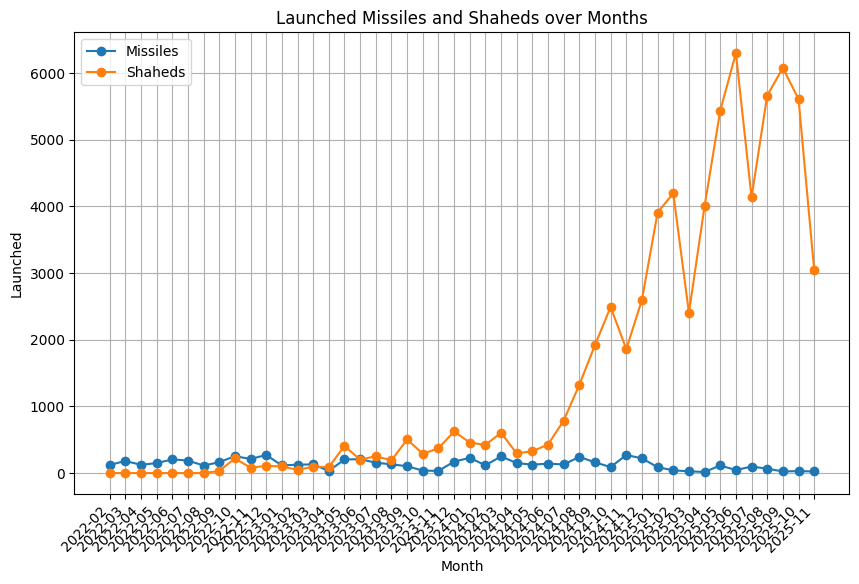

In [138]:
# Побудова лінійного графіка
plt.figure(figsize=(10, 6))  # Задаємо розміри графіка

# Побудова графіка для df_grouped_m
plt.plot(df_grouped_m['month_number'], df_grouped_m['launched'], marker='o', linestyle='-', label='Missiles')
month_numbers_m = df_grouped_m['month_number']  # Всі номери місяців
month_dates_m = df_grouped_m['month']  # Всі дати місяців
plt.xticks(month_numbers_m, month_dates_m, rotation=45, ha='right')  # Відображаємо мітки для df_grouped_m

# Побудова графіка для df_grouped
plt.plot(df_grouped['month_number'], df_grouped['launched'], marker='o', linestyle='-', label='Shaheds')

# Додавання заголовків та підписів до осей
plt.xlabel('Month')
plt.ylabel('Launched')
plt.title('Launched Missiles and Shaheds over Months')

# Додавання легенди
plt.legend()

# Відображення сітки на графіку
plt.grid(True)

# Показ графіка
plt.show()

In [139]:
aggregated_t.tail(30)

,date,intercepted,launched,missile_type,interc_perc
64,2024-04-11,19,31,"Х-101/Х-555/Х-55, Х-59/69, Х-47М, Х-101/Х-555/...",61.3
65,2024-04-19,15,22,"Х-59, Х-22, Х-32 Іскандер, Х-101/Х-555/Х-55",68.2
66,2024-04-27,21,32,"Х-59, Іскандер, Х-47М, Калібр, Х-101/Х-555/Х-55",65.6
67,2024-05-08,33,45,Х-101/Х-555/Х-55,73.3
68,2024-05-26,12,12,Х-101/Х-555/Х-55,100.0
69,2024-05-30,7,11,Х-101/Х-555/Х-55,63.6
70,2024-06-01,30,35,Х-101/Х-555/Х-55,85.7
71,2024-06-07,5,5,Х-101/Х-555/Х-55,100.0
72,2024-06-12,4,4,Х-101/Х-555/Х-55,100.0
73,2024-06-14,7,10,Х-101/Х-555/Х-55,70.0


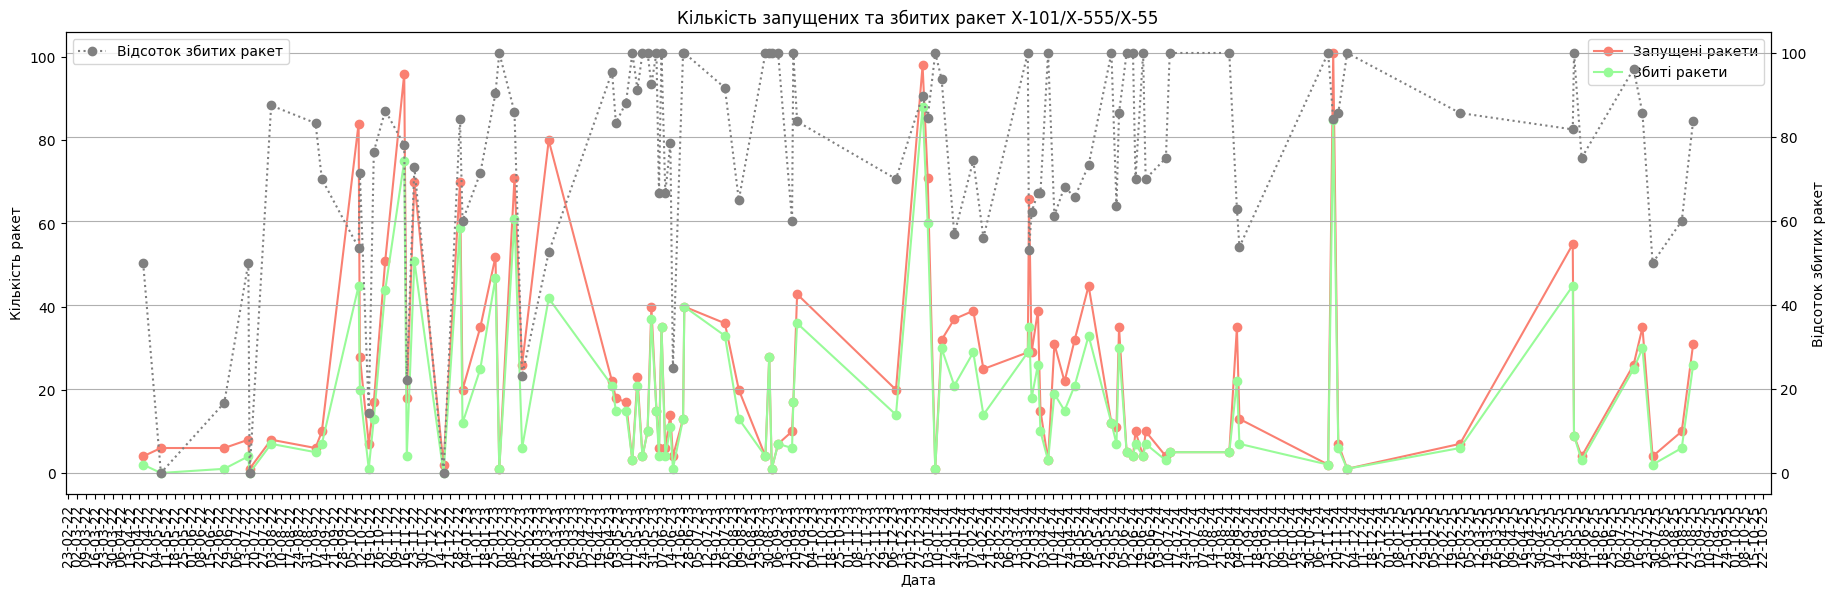

In [140]:
# Створення фігури та осі
fig, ax1 = plt.subplots(figsize=(22, 6))

# Побудова графіків кількості запущених ракет та кількості збитих ракет на основній осі y
ax1.plot(aggregated_t['date'], aggregated_t['launched'], color='salmon', marker='o', linestyle='-', label='Запущені ракети')
ax1.plot(aggregated_t['date'], aggregated_t['intercepted'], color='palegreen', marker='o', linestyle='-', label='Збиті ракети')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Кількість ракет')
ax1.set_title('Кількість запущених та збитих ракет Х-101/Х-555/Х-55')
ax1.tick_params(axis='x', rotation=90)
ax1.legend()

# Створення додаткової осі y для відсотка збитих ракет
ax2 = ax1.twinx()
ax2.plot(aggregated_t['date'], aggregated_t['interc_perc'], color='gray', marker='o', linestyle=':', label='Відсоток збитих ракет')
ax2.set_ylabel('Відсоток збитих ракет')
ax2.legend()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))  # Встановлюємо формат дати
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Встановлюємо крок в 7 днів для відображення
plt.grid(True)  # Включаємо сітку
plt.show()

In [141]:
!pip install xlsxwriter

# Створюємо ExcelWriter для запису в один файл на різні аркуші
with pd.ExcelWriter('/content/drive/MyDrive/Colab Notebooks/таблички.xlsx', engine='xlsxwriter') as writer:
    shahed_agg.to_excel(writer, sheet_name='Шахеди', index=False)
    missiles_agg.to_excel(writer, sheet_name='Ракети', index=False)

In [142]:
data_json = {
    "stat": {
        "title": "=============СТАТИСТИКА===============",
        "value": ''
    },
    "month_total": {
        "title": "Сума запущених дронів за останній місяць",
        "value": int(total_launched)
    },
    "month_failed": {
        "title": "Сума дронів, що не досягли цілі за останній місяць",
        "value": int(total_intercepted)
    },
    "AD_efficiency": {
        "title": "Ефективність ППО",
        "value": f"{round(total_intercepted / total_launched * 100, 2)}%"
    },
    "week_total": {
        "title": "Сума запущених дронів за минулий тиждень",
        "value": int(last_week_data['launched'].sum())
    },
    "record": {
        "title": "===============РЕКОРДИ=================",
        "value": ''
    },
    "max_month": {
            "title": "Рекордним місяцем за кількістю запусків був",
            "value": f"{month_name} {year}",
            "drones": int(max_value)
    },
    "max_day": {
            "title": "Рекордним днем за кількістю запусків було",
            "value": f"{day_number}-е {month_name_d} {year_d}",
            "drones": int(max_value_day)
    },
    "predict": {
        "title": "===============ПРОГНОЗ=================",
        "value": ''
    },
    "expected_total": {
        "title": "Очікувана кількість запущених дронів за місяць (за умови збереження тенденції)",
        "value": int(total_launched / last_month_data.date.max().day * days_in_month)
    }
}

# Запис у JSON-файл
with open("/content/drive/MyDrive/Colab Notebooks/shaheds_for_alphabot.json", "w", encoding="utf-8") as file:
    json.dump(data_json, file, ensure_ascii=False, indent=2)

In [143]:
today_data_l = today_data_l if today_data_l > 0 else 'Дані за сьогодні відсутні'
today_data_i = today_data_i if today_data_i > 0 else 'Дані за сьогодні відсутні'

text_for_bot = (
    f"ЗА НІЧ НА {today_day} {today_month}:",
    f"Запущених: {today_data_l}",
    f"Не досягли цілі: {today_data_i}",
    "",
    "ЗА МИНУЛИЙ ТИЖДЕНЬ:",
    f"Запущених: {last_week_data['launched'].sum()}",
    f"Не досягли цілі: {last_week_data['intercepted'].sum()}",
    f"Ефективність ППО: {round(last_week_data['intercepted'].sum() / last_week_data['launched'].sum() * 100, 2)}%",
    "",
    "ЗА ЦЕЙ ТИЖДЕНЬ:",
    f"Запущених: {this_week_data['launched'].sum()}",
    f"Не досягли цілі: {this_week_data['intercepted'].sum()}",
    f"Ефективність ППО: {round(this_week_data['intercepted'].sum() / this_week_data['launched'].sum() * 100, 2)}%",
    "",
    "ЗА ЦЕЙ МІСЯЦЬ:",
    f"Запущених: {total_launched}",
    f"Не досягли цілі: {total_intercepted}",
    f"Ефективність ППО: {round(total_intercepted / total_launched * 100, 2)}%",
    "",
    "РЕКОРДИ:",
    f"Місяць: {month_name} {year} - {max_value} дронів.",
    f"День: {day_number} {month_name_d} {year_d} - {max_value_day} дронів.",
    "",
    "ПРОГНОЗ ПО ЗАПУСКАХ:",
    f"На кінець поточного місяця: {int(total_launched / last_month_data.date.max().day * days_in_month)}", #
    #"",
    #"МУДРІСТЬ ДНЯ:",
    #"Кубіки - то круто!"
)

print("\n".join(text_for_bot))

ЗА НІЧ НА 17 ГРУДНЯ:
Запущених: 66
Не досягли цілі: 37

ЗА МИНУЛИЙ ТИЖДЕНЬ:
Запущених: 1220
Не досягли цілі: 972
Ефективність ППО: 79.67%

ЗА ЦЕЙ ТИЖДЕНЬ:
Запущених: 283
Не досягли цілі: 227
Ефективність ППО: 80.21%

ЗА ЦЕЙ МІСЯЦЬ:
Запущених: 2930
Не досягли цілі: 2338
Ефективність ППО: 79.8%

РЕКОРДИ:
Місяць: липень 2025 - 6297 дронів.
День: 7 вересня 2025 - 810 дронів.

ПРОГНОЗ ПО ЗАПУСКАХ:
На кінець поточного місяця: 5342


In [144]:
with open("/content/drive/MyDrive/Colab Notebooks/shaheds_for_alphabot.txt", "w", encoding="utf-8") as file:
    file.write("\n".join(text_for_bot))

# Запис у файл
with open("shaheds_for_alphabot.txt", "w", encoding="utf-8") as file:
    file.write("\n".join(text_for_bot))

# Завантаження на ПК
#files.download("shaheds_for_alphabot.txt")

# Виконання команди curl
#!curl -T "/content/shaheds_for_alphabot.txt" ftp://codeit.ftp.tools/ --user codeit_oleh:ec8EeH8F64ec8EeH8F64 && rm "/content/shaheds_for_alphabot.txt"